## Introduction:
The research topic treated in this document is "Can we predict wether a movie will be popular based on specific features like genre, budget, release date and reviews on other movies".

## Data collection (see Data collection.ipynb):
This part is a shortcut following the "Data collection.ipynb" file, we will reimport all the packages and the dataset. We divided the data collection from the other parts to not redo the collection step.

<font color='blue'>Run the code to skip the data collection and directly head to the data cleaning section<font> 

In [4]:
import os
import pandas as pd
from tmdbv3api import TMDb, Movie
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import deque
import time
import urllib.request
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [5]:
mv = pd.read_csv('/Users/joni/Documents/Master 1/Data management/data/movieDB_complete.csv')

In [6]:
mv.head(10000)

title  \
0                                 Sikandar Ka Muqaddar   
1                                         Japanese Mom   
2                                           Spellbound   
3                                           The Grinch   
4                                      We Live in Time   
...                                                ...   
5975                                             Rogue   
5976  The Adventures of Priscilla, Queen of the Desert   
5977            Detective Conan: Sunflowers of Inferno   
5978                                         Breakdown   
5979                                          Invictus   

                                                 genres  popularity  \
0            ['Thriller', 'Crime', 'Mystery', 'Action']     375.316   
1                                  ['Romance', 'Drama']     353.716   
2     ['Animation', 'Fantasy', 'Family', 'Adventure'...     326.983   
3          ['Animation', 'Family', 'Comedy', 'Fantasy']     360.162   
4                                  ['Romance', 'Drama']     370.593   
...                                                 ...         ...   
5975                   ['Action', 'Horror', 'Thriller']      25.390   
5976                                ['Drama', 'Comedy']      24.388   
5977     ['Animation', 'Crime', 'Adventure', 'Mystery']      17.892   
5978                   ['Crime', 'Mystery', 'Thriller']      28.138   
5979                               ['Drama', 'History']      27.065   

     release_date    budget    revenue  vote_count  vote_average    status  \
0      2024-11-29         0          0          12         6.100  Released   
1      2017-02-09         0          0          30         6.200  Released   
2      2024-11-22         0          0         159         6.900  Released   
3      2018-11-08  75000000  508600000        3984         6.900  Released   
4      2024-10-10  20000000   31818409         227         7.597  Released   
...           ...       ...        ...         ...           ...       ...   
5975   2007-11-08  20000000    4600000         684         6.400  Released   
5976   1994-05-31   2000000   29700000         795         7.281  Released   
5977   2015-04-18         0   52920296         115         6.100  Released   
5978   1997-05-02  36000000   50159144         923         6.900  Released   
5979   2009-12-11  60000000  122400000        4087         7.183  Released   

      runtime     imdb_id  Metascore  imdbRating  
0         143  tt31522415        NaN         NaN  
1          91         NaN        NaN         NaN  
2         111   tt7215232        NaN         6.3  
3          85   tt2709692       51.0         6.4  
4         108  tt27131358       59.0         7.0  
...       ...         ...        ...         ...  
5975       99   tt0479528        NaN         6.2  
5976      103   tt0109045       70.0         7.5  
5977      113   tt3737650        NaN         6.2  
5978       93   tt0118771       73.0         7.0  
5979      134   tt1057500       74.0         7.3  

[5980 rows x 13 columns]

## Data cleaning

In this section, we will clean the database from any missing values, non-useful observations (movies that are not released and hence do not have any reviews / revenues/..).

First we will drop the missing values from the variables: release_date, budget, revenu, imdb_id, Metascore and imdbRating. Then, we will filter out rows with zero values in critical columns such as budget, revenue, and runtime to ensure data consistency for analysis. 

In [9]:
# Drop rows with NaN values in critical columns
mv = mv.dropna(subset=['release_date', 'budget', 'revenue','imdb_id','Metascore','imdbRating'])

# Filter out rows with zero values in budget or revenue
mv = mv[(mv['budget'] > 0) & (mv['revenue'] > 0) & (mv['runtime'] > 0)]

# Check the dataset after cleaning
print("Dataset after removing missing or zero values:")
mv.head(10000)


Dataset after removing missing or zero values:


title  \
3                                           The Grinch   
4                                      We Live in Time   
5                                               Azrael   
8                       Home Alone 2: Lost in New York   
11                                               Anora   
...                                                ...   
5972                                          Due Date   
5973                                        The Player   
5976  The Adventures of Priscilla, Queen of the Desert   
5978                                         Breakdown   
5979                                          Invictus   

                                            genres  popularity release_date  \
3     ['Animation', 'Family', 'Comedy', 'Fantasy']     360.162   2018-11-08   
4                             ['Romance', 'Drama']     370.593   2024-10-10   
5                 ['Action', 'Horror', 'Thriller']     329.154   2024-09-27   
8                ['Comedy', 'Family', 'Adventure']     361.064   1992-11-15   
11                  ['Romance', 'Comedy', 'Drama']     437.105   2024-10-14   
...                                            ...         ...          ...   
5972                           ['Comedy', 'Drama']      22.605   2010-11-03   
5973    ['Mystery', 'Drama', 'Thriller', 'Comedy']      27.139   1992-04-03   
5976                           ['Drama', 'Comedy']      24.388   1994-05-31   
5978              ['Crime', 'Mystery', 'Thriller']      28.138   1997-05-02   
5979                          ['Drama', 'History']      27.065   2009-12-11   

        budget    revenue  vote_count  vote_average    status  runtime  \
3     75000000  508600000        3984         6.900  Released       85   
4     20000000   31818409         227         7.597  Released      108   
5     12000000     631272         148         5.980  Released       86   
8     18000000  358994850        9631         6.750  Released      120   
11     6000000   25467529         404         7.300  Released      139   
...        ...        ...         ...           ...       ...      ...   
5972  65000000  211800000        5388         6.381  Released       95   
5973   8000000   21706101         811         7.200  Released      124   
5976   2000000   29700000         795         7.281  Released      103   
5978  36000000   50159144         923         6.900  Released       93   
5979  60000000  122400000        4087         7.183  Released      134   

         imdb_id  Metascore  imdbRating  
3      tt2709692       51.0         6.4  
4     tt27131358       59.0         7.0  
5     tt22173666       52.0         5.4  
8      tt0104431       46.0         6.9  
11    tt28607951       91.0         8.0  
...          ...        ...         ...  
5972   tt1231583       51.0         6.5  
5973   tt0105151       86.0         7.5  
5976   tt0109045       70.0         7.5  
5978   tt0118771       73.0         7.0  
5979   tt1057500       74.0         7.3  

[3288 rows x 13 columns]

In [10]:
mv.value_counts # Check if there are missing values in the dataset

<bound method DataFrame.value_counts of                                                  title  \
3                                           The Grinch   
4                                      We Live in Time   
5                                               Azrael   
8                       Home Alone 2: Lost in New York   
11                                               Anora   
...                                                ...   
5972                                          Due Date   
5973                                        The Player   
5976  The Adventures of Priscilla, Queen of the Desert   
5978                                         Breakdown   
5979                                          Invictus   

                                            genres  popularity release_date  \
3     ['Animation', 'Family', 'Comedy', 'Fantasy']     360.162   2018-11-08   
4                             ['Romance', 'Drama']     370.593   2024-10-10   
5                 ['Action

Below, a check is performed to identify movies that are not marked as "Released". This ensures that the dataset only contains movies that have been released and are relevant for analysis.

Result:

-The not_released DataFrame is empty, indicating that all movies in the dataset have a status of "Released".

-This validation confirms the dataset is clean and consistent with no irrelevant or incomplete entries.

In [12]:
not_released = mv.loc[mv['status'] != "Released"]

print('\nNot released movies :\n', not_released)


Not released movies :
 Empty DataFrame
Columns: [title, genres, popularity, release_date, budget, revenue, vote_count, vote_average, status, runtime, imdb_id, Metascore, imdbRating]
Index: []


In [13]:
# Convert release_date to datetime and handle errors gracefully
mv['release_date'] = pd.to_datetime(mv['release_date'], errors='coerce')

# Extract release_year and release_quarter
mv['release_year'] = mv['release_date'].dt.year
mv['release_quarter'] = mv['release_date'].dt.to_period('Q').astype(str).str[-2:]  # Extract only the quarter part (e.g., Q1, Q2)

# Create the year_quarter column without the year in front of the quarter
mv['year_quarter'] = mv['release_year'].astype(str) + "_" + mv['release_quarter']

# Display the updated DataFrame with year_quarter
print("Dataset with year_quarter column:")
mv[['title', 'release_year', 'release_quarter', 'year_quarter']].head(20)

Dataset with year_quarter column:


title  release_year release_quarter  \
3                                The Grinch          2018              Q4   
4                           We Live in Time          2024              Q4   
5                                    Azrael          2024              Q3   
8            Home Alone 2: Lost in New York          1992              Q4   
11                                    Anora          2024              Q4   
12                                 Pleasure          2021              Q4   
18                                     Flow          2024              Q3   
21                            The Lion King          2019              Q3   
24                                Scream VI          2023              Q1   
26  Harry Potter and the Chamber of Secrets          2002              Q4   
27                                  Titanic          1997              Q4   
29                     John Wick: Chapter 4          2023              Q1   
31         Transformers: Rise of the Beasts          2023              Q2   
32          The Best Christmas Pageant Ever          2024              Q4   
33              The Super Mario Bros. Movie          2023              Q2   
35                       Sonic the Hedgehog          2020              Q1   
38                     Fifty Shades of Grey          2015              Q1   
41                                Migration          2023              Q4   
46                 Avatar: The Way of Water          2022              Q4   
47                            28 Days Later          2002              Q4   

   year_quarter  
3       2018_Q4  
4       2024_Q4  
5       2024_Q3  
8       1992_Q4  
11      2024_Q4  
12      2021_Q4  
18      2024_Q3  
21      2019_Q3  
24      2023_Q1  
26      2002_Q4  
27      1997_Q4  
29      2023_Q1  
31      2023_Q2  
32      2024_Q4  
33      2023_Q2  
35      2020_Q1  
38      2015_Q1  
41      2023_Q4  
46      2022_Q4  
47      2002_Q4

The release_date column was processed to extract temporal features:

Converted to Datetime: Ensuring proper date formatting.

New Features:

-release_year: Extracted from the year of release.

-release_quarter: Identifies the quarter (Q1–Q4) of release.

-year_quarter: Combines year and quarter (e.g., 2024_Q3).

This enables analysis of release patterns and trends. A preview of the updated dataset is shown above.

In [15]:
year_range = (mv['release_year'].min(), mv['release_year'].max())
print(f"Year Range: {year_range}")

Year Range: (1927, 2024)


This section normalizes and combines key variables to create a new weighted metric for analysis:

Variable Ranges:

popularity: Scaled from 0–1000.

Metascore: Scaled from 0–100.

imdbRating: Scaled from 0–10.

In [17]:
popularity_range = (mv['popularity'].min(), mv['popularity'].max())
Metascore_range = (mv['Metascore'].min(), mv['Metascore'].max())
imdbRating_range = (mv['imdbRating'].min(), mv['imdbRating'].max())


print(f"Popularity range: {popularity_range}")
print(f"Metascore range: {Metascore_range}")
print(f"ImdbRating range: {imdbRating_range}")

Popularity range: (13.649, 932.457)
Metascore range: (9.0, 100.0)
ImdbRating range: (2.3, 9.3)


In [18]:
mv['n_popularity'] = ((mv['popularity'] * 20) / 1000).round(2) # Popularity is on a 0-1000 scale
mv['n_metascore'] = ((mv['Metascore'] * 20) / 100).round(2)  # Metascore is on a 0-100 scale
mv['n_imdb'] = ((mv['imdbRating'] * 20) / 10).round(2) # IMDb rating already on a 0-10 scale

# Define the weights (these can be adjusted)
w_popularity = 0.4
w_metascore = 0.3
w_imdb = 0.3

mv['w_popularity'] = (w_popularity * mv['n_popularity'] + w_metascore* mv['n_metascore'] + w_imdb * mv['n_imdb']).round(2)

Custom weights are applied to the normalized variables:

popularity: 40%

Metascore: 30%

imdbRating: 30%

Each variable is scaled to a common range (0–20) to balance their contributions.

In [20]:
w_popularity_range = (mv['w_popularity'].min(), mv['w_popularity'].max())
print(f"w_popularity Range: {w_popularity_range }")

mv['w_popularity'].head(1000)

w_popularity Range: (2.45, 17.43)


3        9.78
4       10.70
5        8.99
8        9.79
11      13.76
        ...  
1727     9.02
1729     6.89
1730     8.03
1733     7.75
1735     7.42
Name: w_popularity, Length: 1000, dtype: float64

The normalized and weighted popularity variable is scaled to approximately range from 0 to 20, with actual values falling between 2.45 and 17.43 in this dataset. The first few entries are displayed above for verification.

In [22]:
upper_10_percentile = mv['w_popularity'].quantile(0.9025)

# Define a function to assign popularity_class based on the global threshold
def assign_popularity_class(group):
    # Use the pre-calculated threshold (the same across all groups)
    group['popularity_class'] = (group['w_popularity'] >= upper_10_percentile).astype(int)  # Top 10% = 1, others = 0
    return group

# Apply the function to group by 'year_quarter'
mv = mv.groupby('year_quarter', group_keys=False).apply(assign_popularity_class)

# Ensure the dataset is sorted by 'year_quarter'
mv = mv.sort_values(by='year_quarter')

# Display the sorted dataset with the new 'popularity_class'
print("\nDataset organized by year and quarter:")
mv[['title', 'year_quarter', 'w_popularity', 'popularity_class']].head(100)


Dataset organized by year and quarter:


/var/folders/kg/fz4w85nn12d7c6vmk5_0_5x80000gn/T/ipykernel_82095/1101810327.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mv = mv.groupby('year_quarter', group_keys=False).apply(assign_popularity_class)


title year_quarter  w_popularity  \
2405                      Metropolis      1927_Q1         11.11   
4829  All Quiet on the Western Front      1930_Q2         10.48   
5547                         Dracula      1931_Q1          8.89   
5181                    Frankenstein      1931_Q4         10.33   
5123                        Scarface      1932_Q2         10.26   
...                              ...          ...           ...   
2046           The Battle of Algiers      1966_Q3         10.81   
3967                          Batman      1966_Q3          8.31   
376   The Good, the Bad and the Ugly      1966_Q4         11.36   
2829           A Man for All Seasons      1966_Q4          9.12   
3942                   Casino Royale      1967_Q2          6.12   

      popularity_class  
2405                 1  
4829                 1  
5547                 0  
5181                 1  
5123                 1  
...                ...  
2046                 1  
3967                 0  
376                  1  
2829                 0  
3942                 0  

[100 rows x 4 columns]

Above, a new popularity_class column is added to classify movies based on their w_popularity score:

Top 10% Threshold: The 90th percentile of w_popularity is calculated as the threshold (value=10.0).

Class Assignment: Movies in the top 10% (w_popularity >= threshold) are labeled 1, and others are labeled 0.

Grouping and Sorting: Data is grouped by year_quarter, and the new class is assigned uniformly within each group.
The dataset is sorted by year_quarter for organized display.

This provides a clear distinction between highly popular and less popular movies.

In [24]:
upper_10_percentile = mv['w_popularity'].quantile(0.9025)
print(upper_10_percentile)

10.0


In [25]:
# Ensure 'genres' column is formatted as lists of genres
# If genres are stored as strings, convert them to lists first
if isinstance(mv['genres'].iloc[0], str):
    mv['genres'] = mv['genres'].apply(eval)

# Perform one-hot encoding on the 'genres' column
genres_dummies = mv['genres'].apply(lambda x: '|'.join(x)).str.get_dummies()

# Concatenate the dummy variables back into the main DataFrame
mv = pd.concat([mv, genres_dummies], axis=1)

# Drop the original 'genres' column as it is now encoded
mv.drop(columns=['genres'], inplace=True)

# Display the updated dataset with one-hot encoded genres
print("After one-hot encoding genres:")
print(mv.head(10))


After one-hot encoding genres:
                                title  popularity release_date   budget  \
2405                       Metropolis      31.602   1927-02-06  5300000   
4829   All Quiet on the Western Front      19.593   1930-04-29  1448864   
5547                          Dracula      23.498   1931-02-12   355000   
5181                     Frankenstein      24.163   1931-11-21   291000   
5123                         Scarface      29.692   1932-04-09   800000   
5156                        King Kong      26.480   1933-03-15   672000   
4458                     Modern Times      19.718   1936-02-05  1500000   
778   Snow White and the Seven Dwarfs      67.379   1938-01-14  1488423   
3578                       Stagecoach      32.198   1939-03-03   531374   
689                  The Wizard of Oz      68.087   1939-08-15  2777000   

        revenue  vote_count  vote_average    status  runtime    imdb_id  ...  \
2405    1350322        2762         8.100  Released      148  t

The genres column is processed and one-hot encoded for machine learning compatibility:

Formatting: Converts genres from strings to lists if necessary.

One-Hot Encoding: Uses str.get_dummies to create binary columns for each unique genre.

Integration: Encoded columns are added to the main DataFrame, and the original genres column is dropped.

The updated dataset above now includes one-hot encoded genre features.


In [27]:
genre_columns = genres_dummies.columns
genres_only = mv[genre_columns]
print("Only genre columns:")
print(genres_only.head(10))

Only genre columns:
      Action  Adventure  Animation  Comedy  Crime  Drama  Family  Fantasy  \
2405       0          0          0       0      0      1       0        0   
4829       0          0          0       0      0      1       0        0   
5547       0          0          0       0      0      0       0        0   
5181       0          0          0       0      0      1       0        0   
5123       0          0          0       0      1      1       0        0   
5156       0          1          0       0      0      0       0        1   
4458       0          0          0       1      0      1       0        0   
778        0          0          1       0      0      0       1        1   
3578       0          1          0       0      0      0       0        0   
689        0          1          0       0      0      0       1        1   

      History  Horror  Music  Mystery  Romance  Science Fiction  Thriller  \
2405        0       0      0        0        0         

This step above isolates the one-hot encoded genre columns:

Identify Genre Columns: genre_columns is extracted from the genres_dummies DataFrame.

Create a Subset: genres_only contains only the binary genre columns.

The result is a streamlined view of genre features, ready for focused analysis.

The cleaned and enriched dataset is now ready for further exploration and predictive modeling.

# Graphical representation

## Correlation matrix

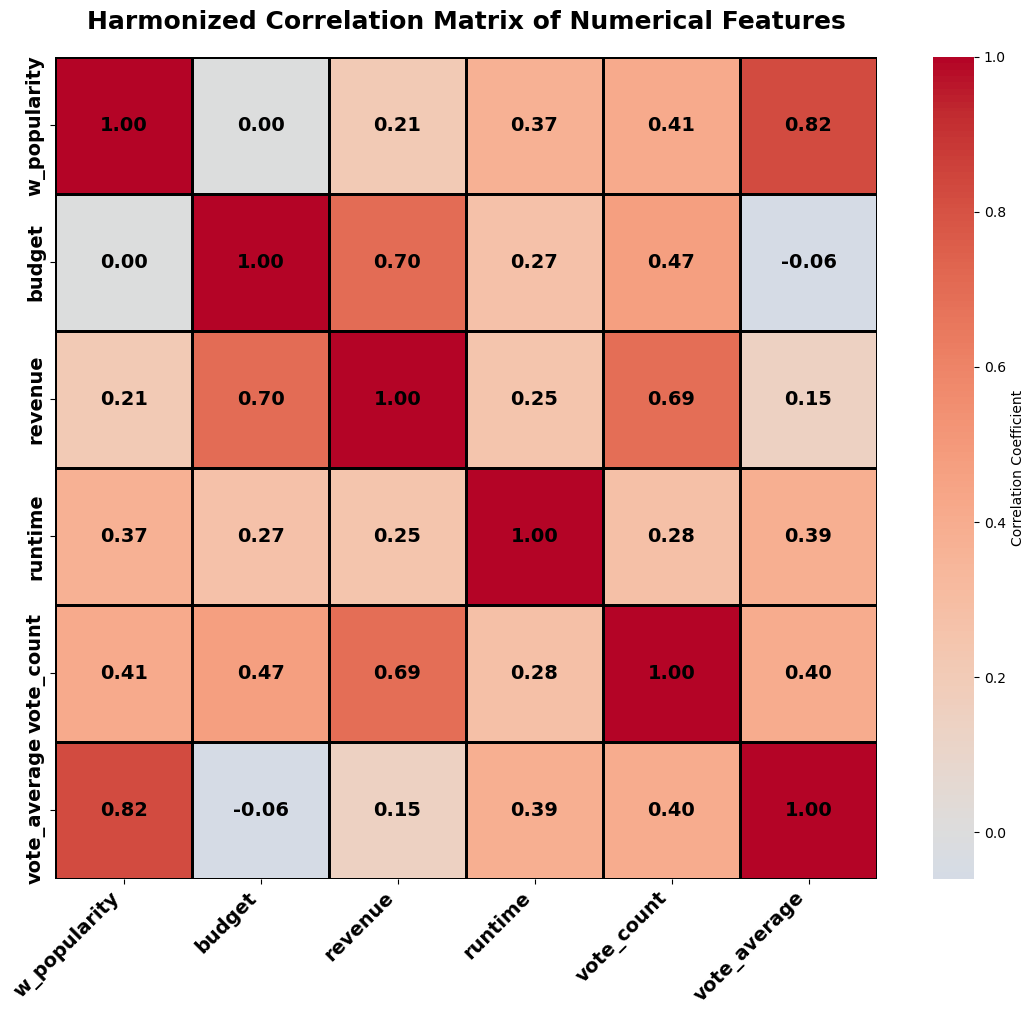

In [32]:
# Step 1: Calculate the correlation matrix for numeric features
numeric_columns = ['w_popularity', 'budget', 'revenue','runtime', 'vote_count', 'vote_average']
correlation_matrix = mv[numeric_columns].corr().round(2)

# Step 2: Create a heatmap with a harmonized diverging colormap
plt.figure(figsize=(12, 10))  # Increased figure size for better readability

# Create the heatmap with formal styling
sns.heatmap(
    correlation_matrix,
    annot=True,           # Annotate the cells with correlation coefficients
    cmap="coolwarm",      # A more professional diverging colormap
    fmt=".2f",            # Format numbers to two decimal places
    center=0,             # Ensure 0 is the center of the colormap
    cbar_kws={"label": "Correlation Coefficient"},  # Add a label to the colorbar
    square=True,          # Make cells square for symmetry
    linewidths=0.8,       # Thin gridlines for separation
    linecolor='black',    # Darker line color for gridlines
    annot_kws={"size": 14, "weight": "bold", "color": "black"}  # Bold annotation text
)

# Step 3: Add title and axis labels with formal styling
plt.title("Harmonized Correlation Matrix of Numerical Features", fontsize=18, fontweight='bold', pad=20)
plt.xticks(fontsize=14, rotation=45, ha='right', fontweight='bold')  # Rotate x-axis labels for readability
plt.yticks(fontsize=14, fontweight='bold')  # Bold y-axis labels for emphasis

# Show the plot
plt.tight_layout()  # Ensures no clipping of labels
plt.show()


The correlation matrix above was computed and visualized to identify relationships between key numerical features (w_popularity, budget, revenue, vote_count, vote_average):

High Correlations:

w_popularity and vote_average (0.82): Suggests that higher average ratings are associated with greater weighted popularity.

budget and revenue (0.70): Indicates a strong relationship between a movie's budget and its revenue.

revenue and vote_count (0.69): More votes often correlate with higher revenue.


Low Correlations:

budget and vote_average (-0.06): Little to no relationship.

The heatmap highlights these relationships using a diverging colormap for clarity, aiding in understanding dependencies.

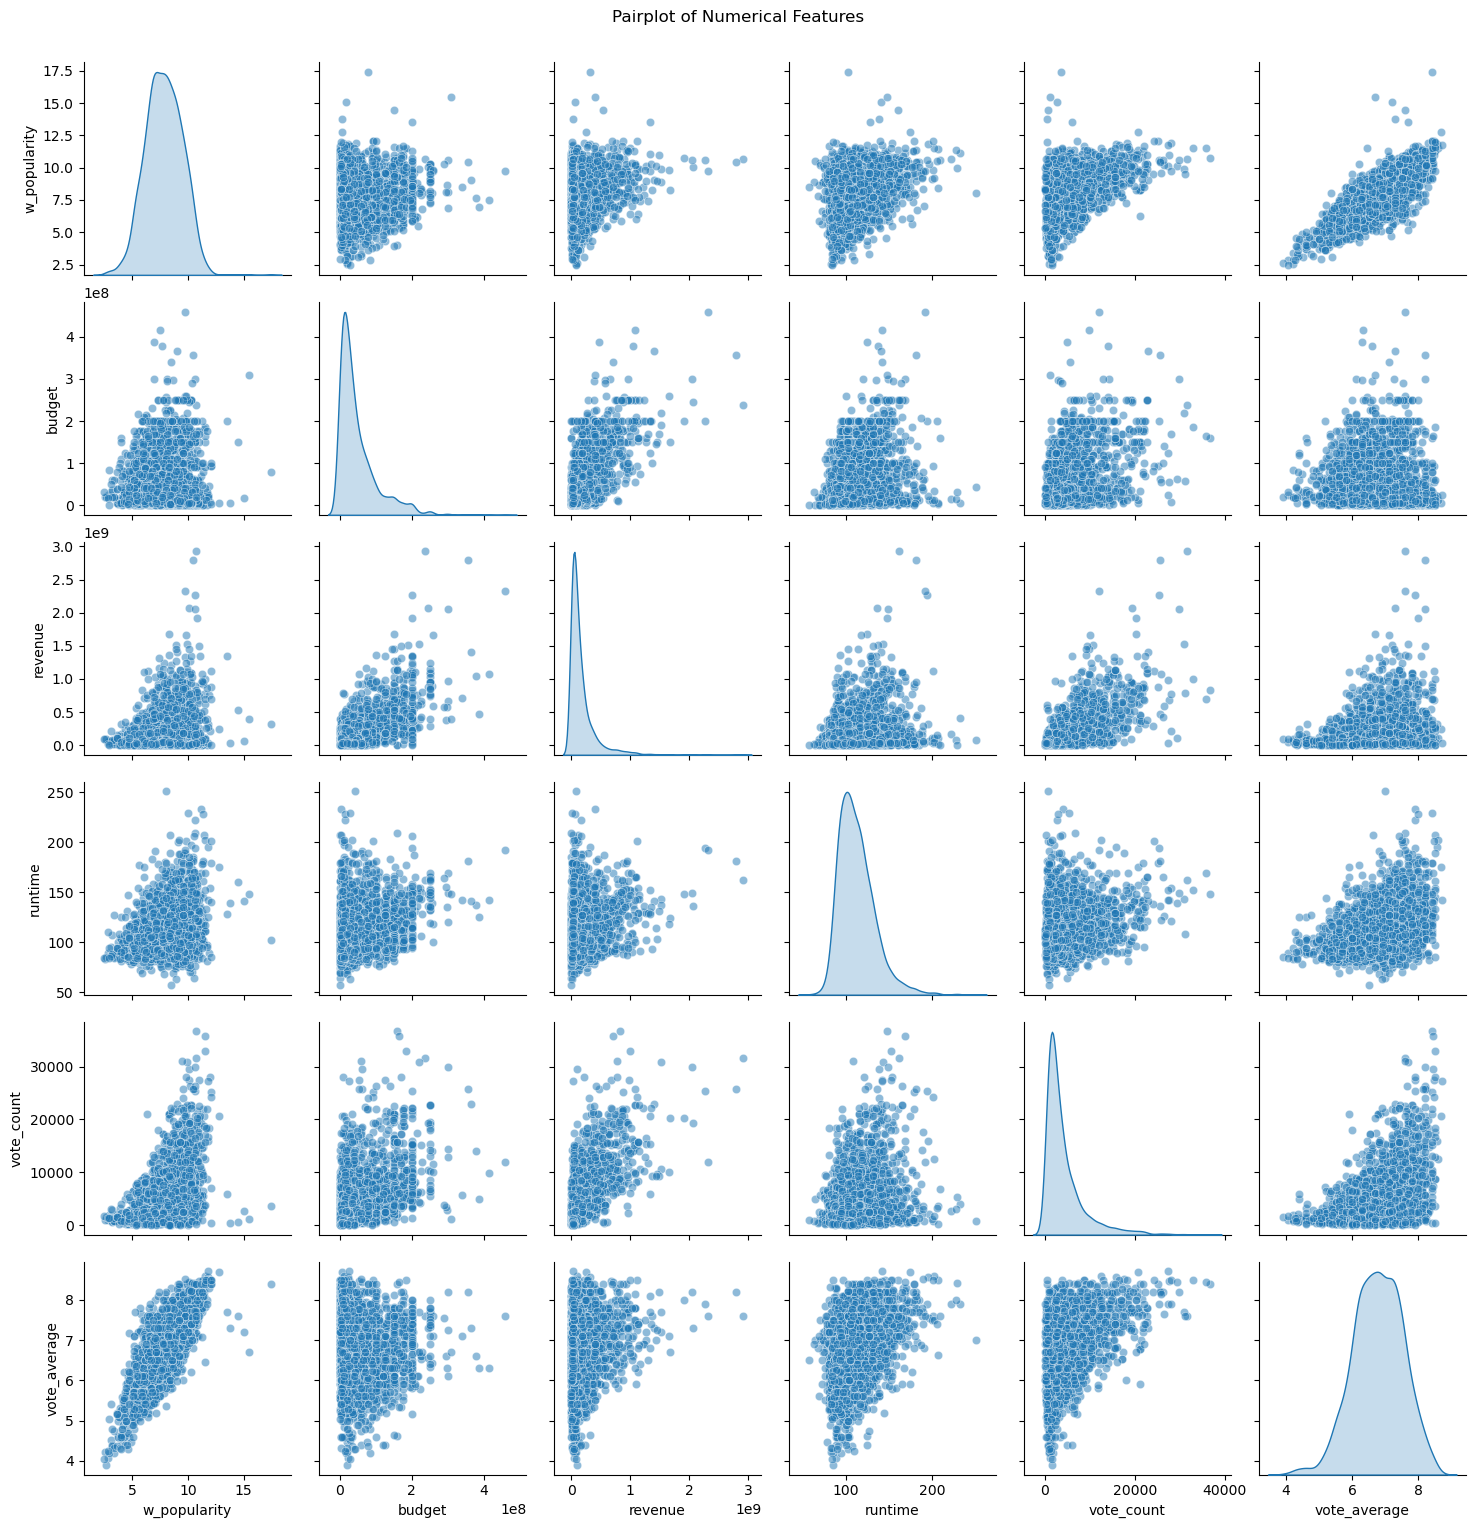

In [34]:
# Select numerical columns for pairplot
numerical_features = ['w_popularity', 'budget', 'revenue','runtime' ,'vote_count', 'vote_average']

# Create a pairplot
sns.pairplot(mv[numerical_features], diag_kind='kde', plot_kws={'alpha':0.5})

# Show the plot
plt.suptitle("Pairplot of Numerical Features", y=1.02)  # Title
plt.show()


A pairplot was created to explore relationships between key numerical features (w_popularity, budget, revenue, vote_count, vote_average):

Diagonal: Kernel density estimates (KDEs) show the distribution of each feature.

Scatterplots: Highlight potential linear or non-linear correlations between feature pairs (e.g., budget vs revenue).

This visualization provides an intuitive understanding of feature interactions and individual distributions. (graphical representation of the heat map correlation matrix)

## Genre representation

/var/folders/kg/fz4w85nn12d7c6vmk5_0_5x80000gn/T/ipykernel_82095/1523269608.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette=palette)


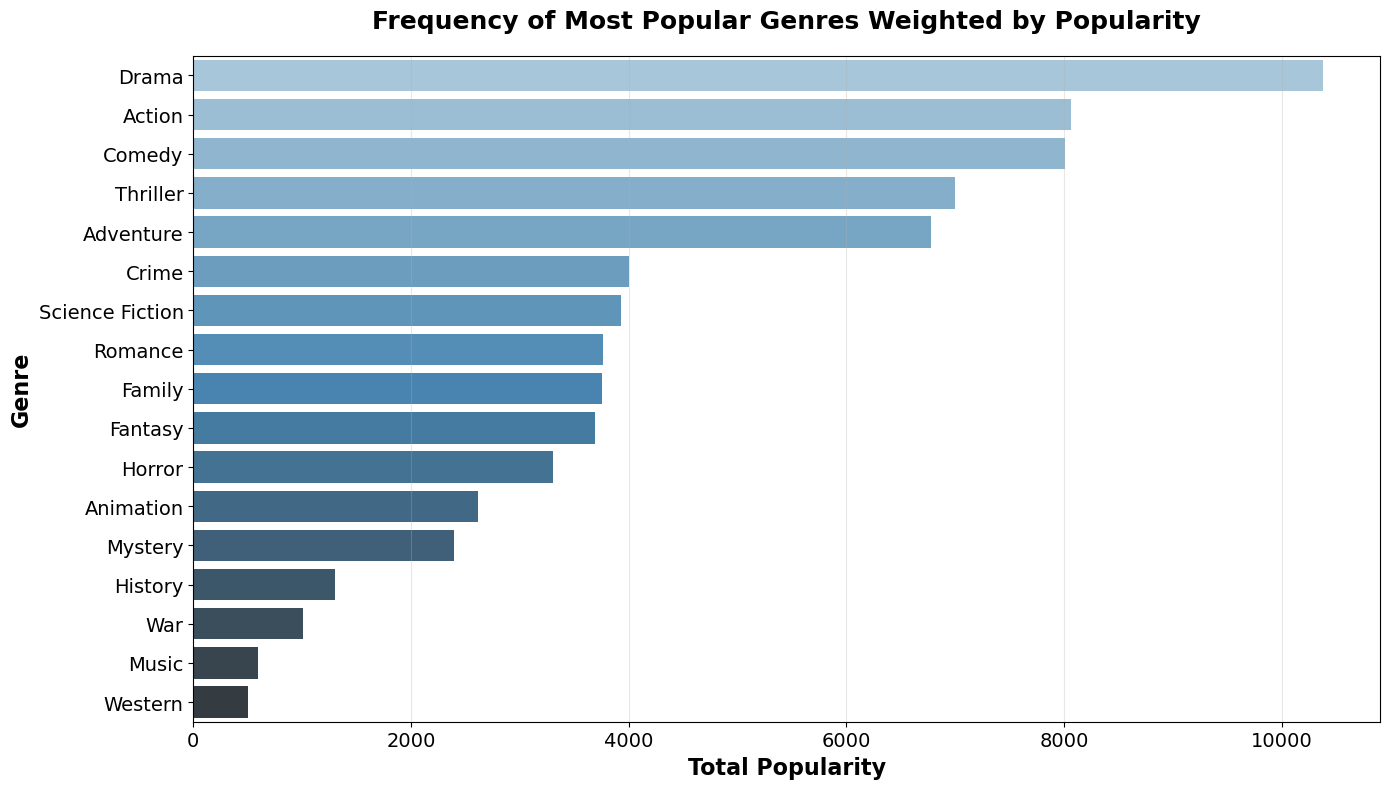

In [37]:
# Convert 'popularity' to numeric (if it's not already)
mv['w_popularity'] = pd.to_numeric(mv['w_popularity'], errors='coerce')

# Identify genre columns by excluding non-genre columns and specific columns
non_genre_columns = [
    'title', 'w_popularity', 'release_date', 'release_year', 
    'release_quarter', 'year_quarter', 'vote_average', 'imdb_id',
    'popularity_class', 'vote_count', 'runtime', 'popularity', 'Metascore', 'n_imdb', 'n_metascore', 'imdbRating', 'n_popularity', 'status', 'revenue','budget'
]
genre_columns = [col for col in mv.columns if col not in non_genre_columns]

# Convert genre columns to numeric (coerce any errors to NaN)
mv[genre_columns] = mv[genre_columns].apply(pd.to_numeric, errors='coerce')

# Handle any NaN values that resulted from the conversion (e.g., by filling with 0)
mv[genre_columns] = mv[genre_columns].fillna(0)

# Aggregate genres by summing their values weighted by popularity
genre_popularity = mv[genre_columns].multiply(mv['w_popularity'], axis=0).sum().sort_values(ascending=False)

# Create a formal frequency bar plot for the most popular genres
plt.figure(figsize=(14, 8))

# Use a formal and neutral color palette (e.g., 'Blues')
palette = sns.color_palette("Blues_d", n_colors=len(genre_popularity))

# Plot the barplot with more formal adjustments
sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette=palette)

# Add title and axis labels with more formal font sizes and weights
plt.title('Frequency of Most Popular Genres Weighted by Popularity', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Total Popularity', fontsize=16, fontweight='bold')
plt.ylabel('Genre', fontsize=16, fontweight='bold')

# Adjust font sizes for ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove gridlines for a cleaner look
plt.grid(axis='x', linestyle='-', alpha=0.3)

# Adjust the layout and ensure it's tight
plt.tight_layout()

# Show the plot
plt.show()


This analysis identifies the most popular movie genres weighted by w_popularity:

Data Processing: genres columns are isolated, converted to numeric, and filled with zeros where necessary.
Values are aggregated and weighted by w_popularity.

Visualization: A bar plot shows the total weighted popularity for each genre.
The most popular genres include Drama, Action, and Comedy, indicating their widespread appeal.

This provides insights into genre performance based on audience popularity. What could be interesting is to compare the popular genre with the predictive models and see if they are the same or not.


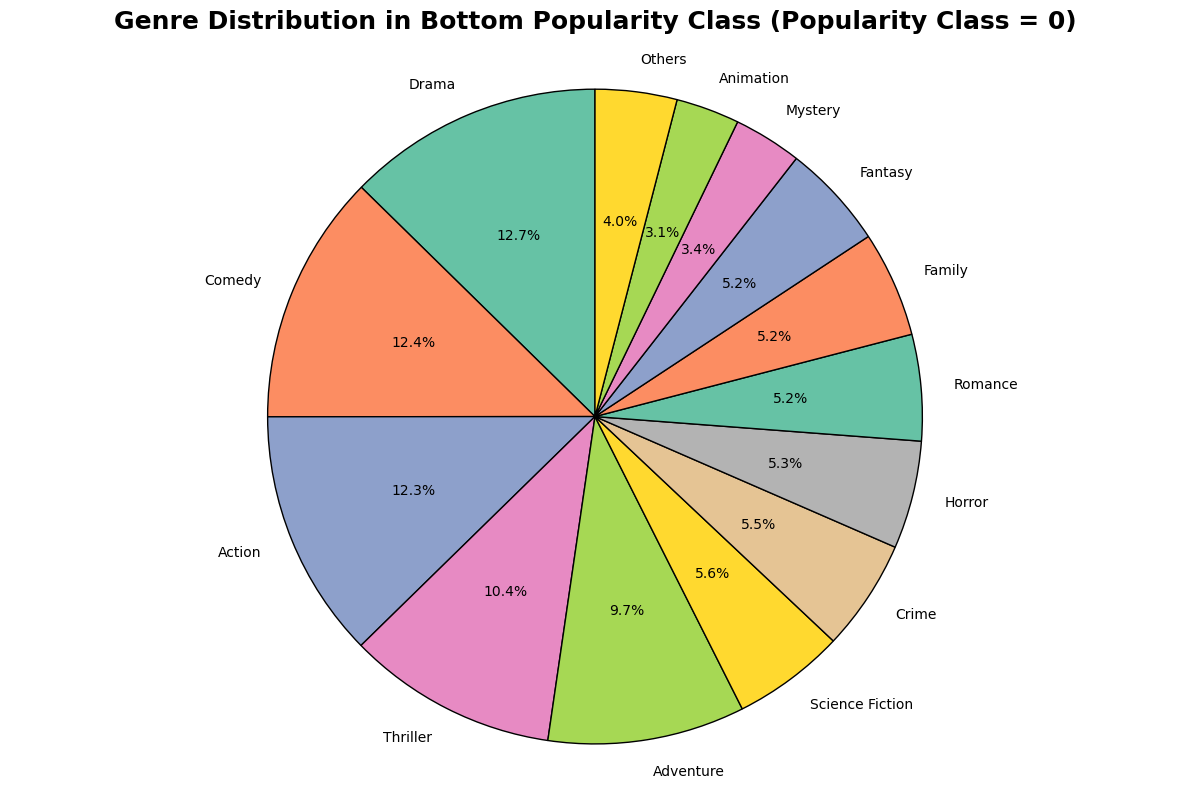

In [39]:
# Filter the dataset for the bottom 90% in popularity_class (i.e., where popularity_class == 0)
bottom_popularity = mv[mv['popularity_class'] == 0]

# Identify genre columns by excluding non-genre columns (adjust based on your dataset)
non_genre_columns = [
    'title', 'w_popularity', 'release_date', 'release_year', 
    'release_quarter', 'year_quarter', 'vote_average', 'imdb_id',
    'popularity_class', 'vote_count', 'runtime', 'popularity', 'Metascore', 'n_imdb', 'n_metascore', 'imdbRating', 'n_popularity', 'status', 'revenue','budget'
]
genre_columns = [col for col in mv.columns if col not in non_genre_columns]

# Sum the values across all genre columns to get the total number of occurrences of each genre
genre_counts = bottom_popularity[genre_columns].sum().sort_values(ascending=False)

# Calculate the total sum for normalization
total_genres = genre_counts.sum()

# Find genres that contribute to less than 3% of the total
threshold = 0.03  # 3% threshold
small_genres = genre_counts[genre_counts / total_genres < threshold]

# Aggregate the small genres into "Others"
others = small_genres.sum()
genre_counts = genre_counts[genre_counts / total_genres >= threshold]

# Add "Others" to the genre_counts
genre_counts['Others'] = others

# Plot a formal circular pie chart
plt.figure(figsize=(12, 8))

# Create the pie chart with a more visible and distinct color palette
colors = sns.color_palette("Set2", n_colors=len(genre_counts))  # 'Set2' provides distinct, easy-to-differentiate colors
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})

# Title and styling
plt.title('Genre Distribution in Bottom Popularity Class (Popularity Class = 0)', fontsize=18, fontweight='bold', pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

# Show the plot
plt.tight_layout()
plt.show()


This analysis examines the genre composition for movies in the bottom 90% of popularity (popularity_class = 0):

Aggregation: Genres are summed and normalized across the dataset.
Minor genres contributing less than 3% are grouped into "Others."

Visualization: A pie chart highlights the proportional representation of each genre.
Drama, Comedy, and Action dominate, each accounting for over 12% of the total.

This provides insights into the typical genres of less popular movies.

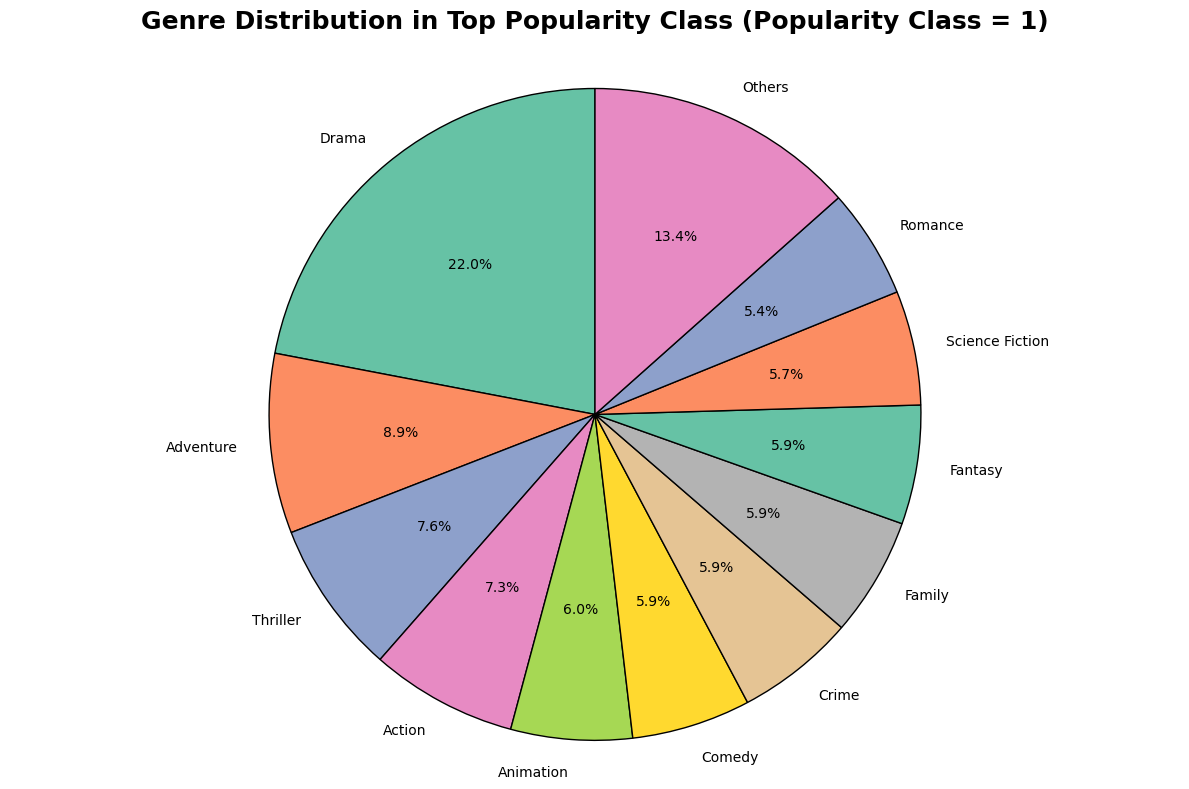

In [41]:
# Filter the dataset for the top 10% in popularity_class (i.e., where popularity_class == 1)
top_popularity = mv[mv['popularity_class'] == 1]

# Identify genre columns by excluding non-genre columns (adjust based on your dataset)
non_genre_columns = [
    'title', 'w_popularity', 'release_date', 'release_year', 
    'release_quarter', 'year_quarter', 'vote_average', 'imdb_id',
    'popularity_class', 'vote_count', 'runtime', 'popularity', 'Metascore', 'n_imdb', 'n_metascore', 'imdbRating', 'n_popularity', 'status', 'revenue','budget'
]
genre_columns = [col for col in mv.columns if col not in non_genre_columns]

# Sum the values across all genre columns to get the total number of occurrences of each genre
genre_counts = top_popularity[genre_columns].sum().sort_values(ascending=False)

# Calculate the total sum for normalization
total_genres = genre_counts.sum()

# Find genres that contribute to less than 3% of the total
threshold = 0.05  # 3% threshold
small_genres = genre_counts[genre_counts / total_genres < threshold]

# Aggregate the small genres into "Others"
others = small_genres.sum()
genre_counts = genre_counts[genre_counts / total_genres >= threshold]

# Add "Others" to the genre_counts
genre_counts['Others'] = others

# Plot a formal circular pie chart
plt.figure(figsize=(12, 8))

# Create the pie chart with a more visible and distinct color palette
colors = sns.color_palette("Set2", n_colors=len(genre_counts))  # 'Set2' provides distinct, easy-to-differentiate colors
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})

# Title and styling
plt.title('Genre Distribution in Top Popularity Class (Popularity Class = 1)', fontsize=18, fontweight='bold', pad=20)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

# Show the plot
plt.tight_layout()
plt.show()


This analysis on the other hand, explores the genre distribution for movies in the top 10% of popularity (popularity_class = 1):

Aggregation: Genres are summed and normalized across the dataset.
Minor genres contributing less than 3% are grouped into "Others."

Visualization: A pie chart highlights the proportional representation of each genre.
Drama leads at 22%, followed by Adventure and Thriller, showing their dominance among highly popular movies.

This illustrates the genres that drive high popularity.

Something interesting can be noticed between both piecharts, which is the appearance of the drama genre in both top (highest shares). Meaning that drama is both the least and the most popular at the same time, which cannot be possible. An explanation could be due to the share of each genre in the dataset (more movies of a certain genre present in the database can influence the results).

## Popularity representation

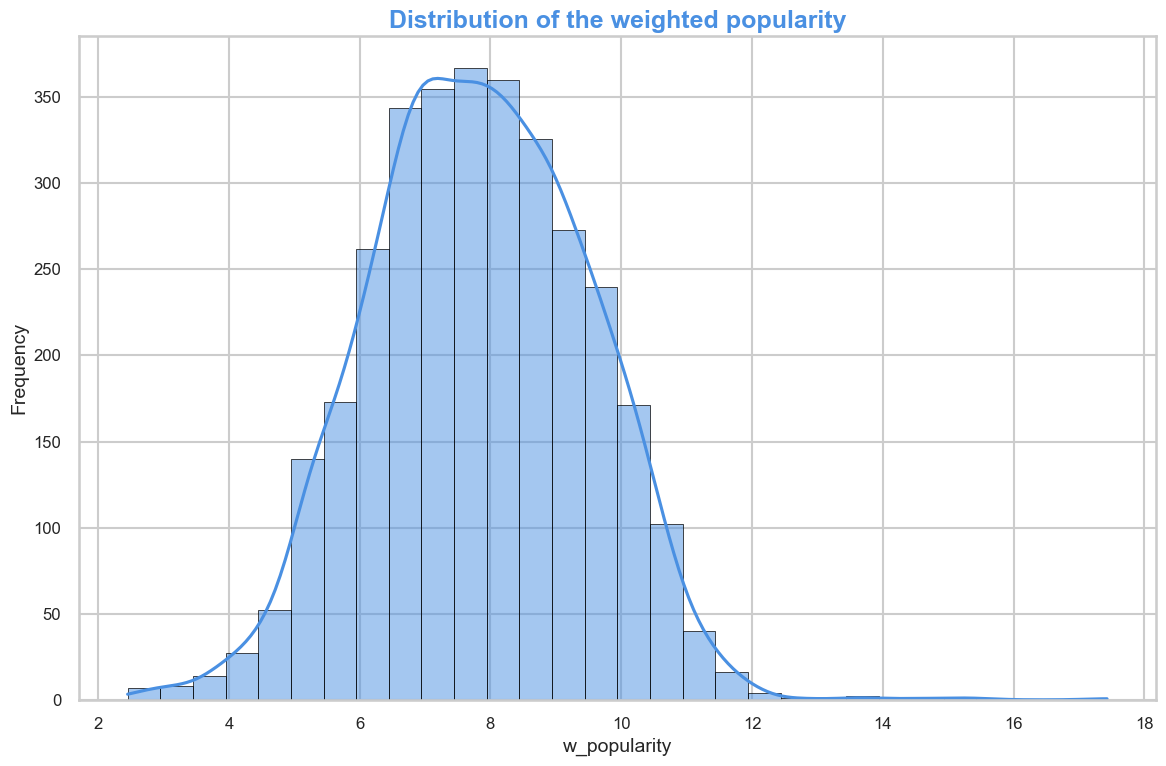

In [44]:
# Set a modern style and context for Seaborn
sns.set_theme(style="whitegrid", context="talk")

# Set the size of the plot
plt.figure(figsize=(12, 8))

# List of features to plot
features = ['w_popularity']

# Define a custom color (blue)
custom_blue = "#4A90E2"  # A soft and vibrant blue color

# Loop through each feature and create a plot
for i, feature in enumerate(features, 1):
    plt.subplot(1, 1, i)  # Only one feature, so use a single plot
    sns.histplot(
        mv[feature],
        kde=True,
        color=custom_blue,
        bins=30,
        edgecolor="black",
        linewidth=0.5,
    )
    plt.title('Distribution of the weighted popularity', fontsize=18, fontweight='bold', color=custom_blue)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

# Add a tight layout and show the plot
plt.tight_layout()
plt.show()


This histogram visualizes the distribution of the w_popularity variable:

The plot shows a near-normal distribution, with the majority of movies having a weighted popularity between 6 and 10.
A kernel density estimate (KDE) curve overlays the histogram for a smoother representation of the data's trend.

This provides information about the central tendency and variability of movie popularity.

We can see that the distribution is centered around approximatively 7.5, meaning that there are more movies below 10 than over it. This can show the share of popular movies based on critics.

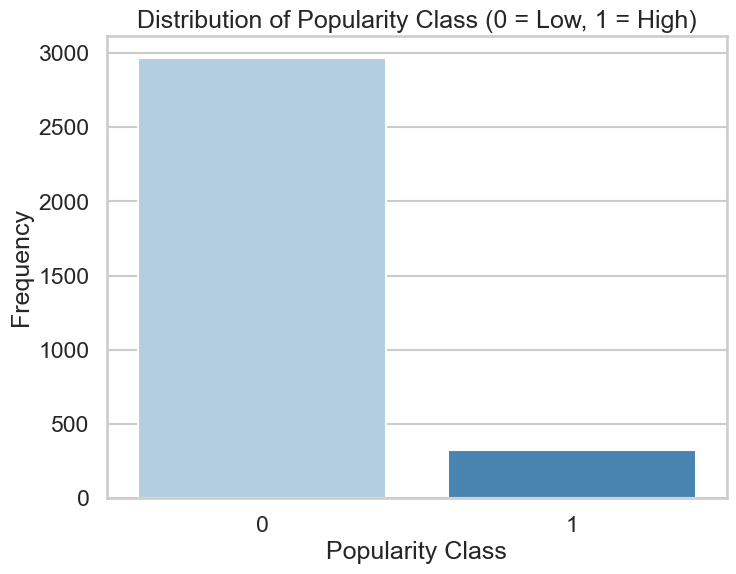

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'popularity_class' is the target variable with 0 and 1
plt.figure(figsize=(8, 6))

# Create a bar plot
sns.countplot(data=mv, x='popularity_class', hue='popularity_class', palette='Blues', dodge=False)
plt.legend([],[], frameon=False)  # Remove legend for clarity

# Add labels and title
plt.xlabel('Popularity Class')
plt.ylabel('Frequency')
plt.title('Distribution of Popularity Class (0 = Low, 1 = High)')

# Show the plot
plt.show()


This bar plot visualizes the distribution of movies across popularity_class categories:

Class 0 (Low Popularity): Represents the majority of the dataset.

Class 1 (High Popularity): A smaller subset indicating highly popular movies.

This highlights the imbalance between low and high popularity movies due to our imposed threshold.

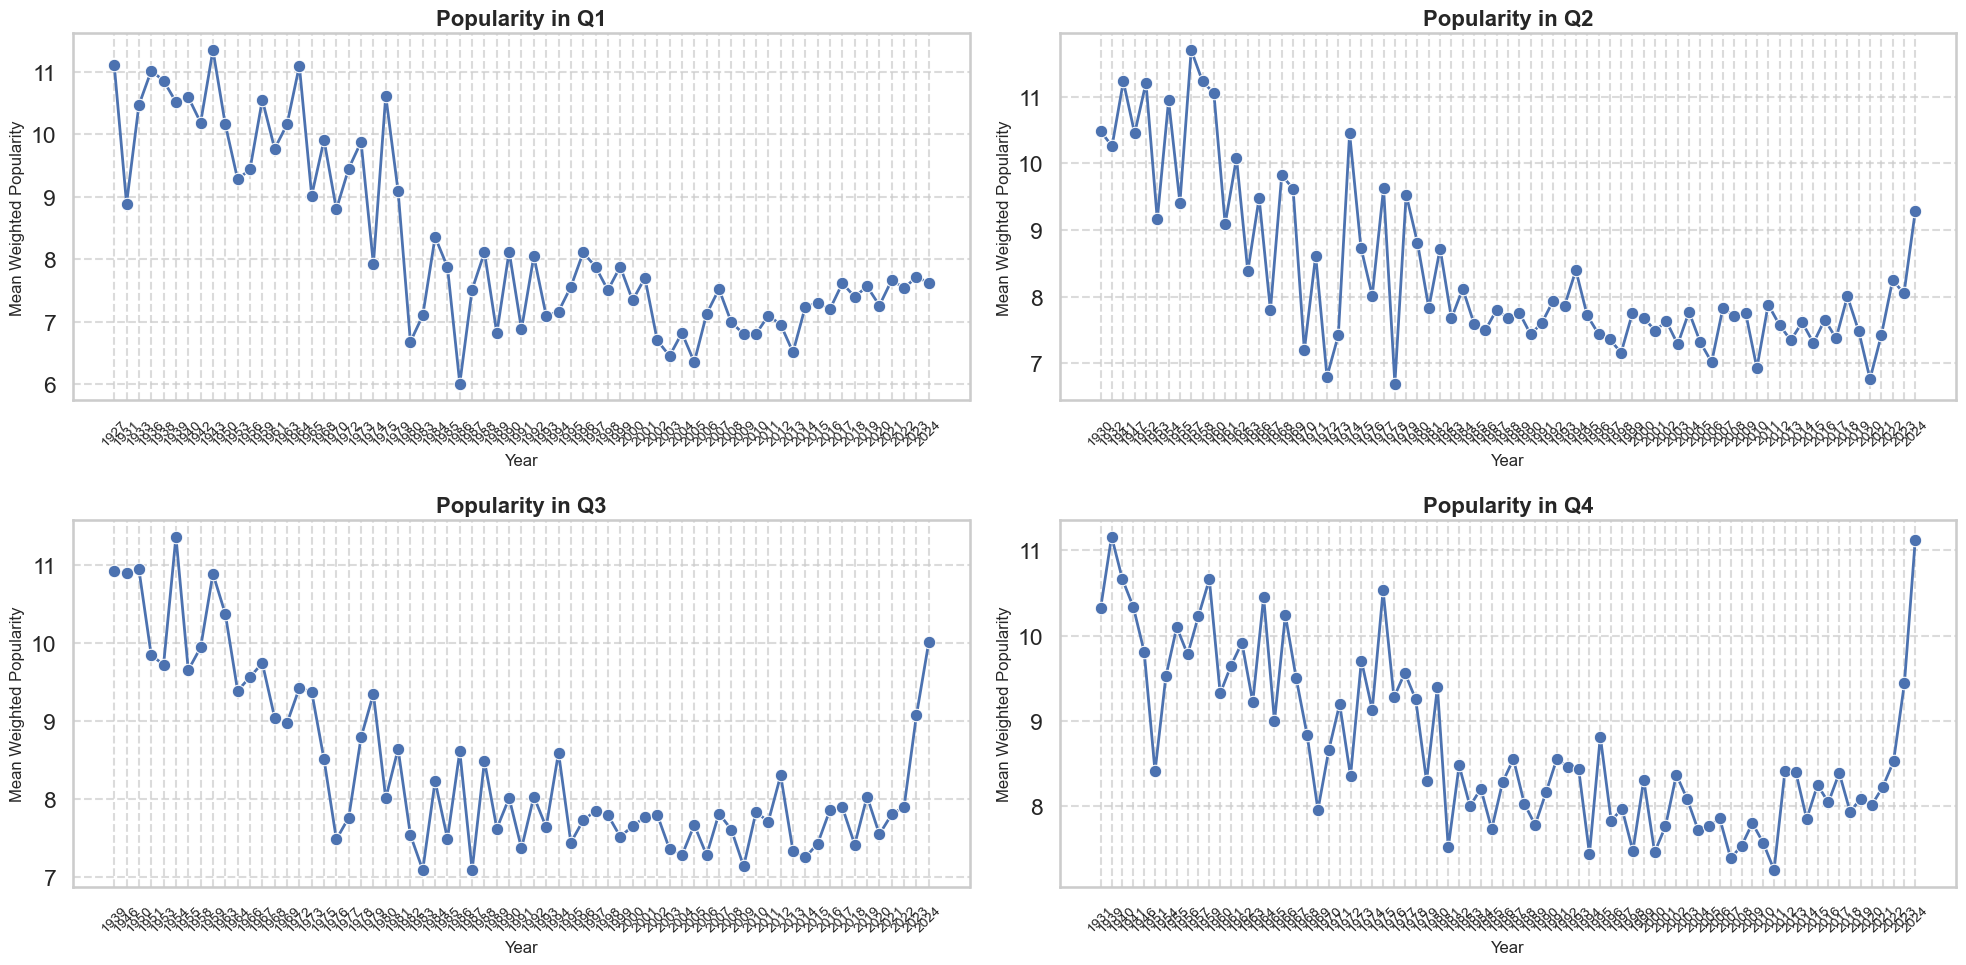

In [48]:
# Create a new column to extract the quarter from 'year_quarter'
mv['quarter'] = mv['year_quarter'].str.split('_').str[1]
mv['year'] = mv['year_quarter'].str.split('_').str[0]  # Extract the year

# Loop through each quarter and plot separately
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
plt.figure(figsize=(20, 10))

for i, quarter in enumerate(quarters, 1):
    # Filter data for the current quarter
    quarter_data = mv[mv['quarter'] == quarter].groupby('year')['w_popularity'].mean().reset_index()
    
    # Plot each quarter in a separate subplot
    plt.subplot(2, 2, i)
    sns.lineplot(x='year', y='w_popularity', data=quarter_data, marker='o', linewidth=2)
    plt.title(f'Popularity in {quarter}', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean Weighted Popularity', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


This visualization examines the average weighted popularity (w_popularity) over time, segmented by each quarter:

Separate Line Plots: Each quarter (Q1–Q4) has its own subplot, showing yearly trends.

Insights: Seasonal variations in popularity are evident.
Popularity fluctuates across years within each quarter, reflecting changing audience preferences and industry patterns.

This provides a detailed view of how movie popularity evolves seasonally over time.

The trends are mostly the same, the effect of the time period on the popularity is still uncertain.

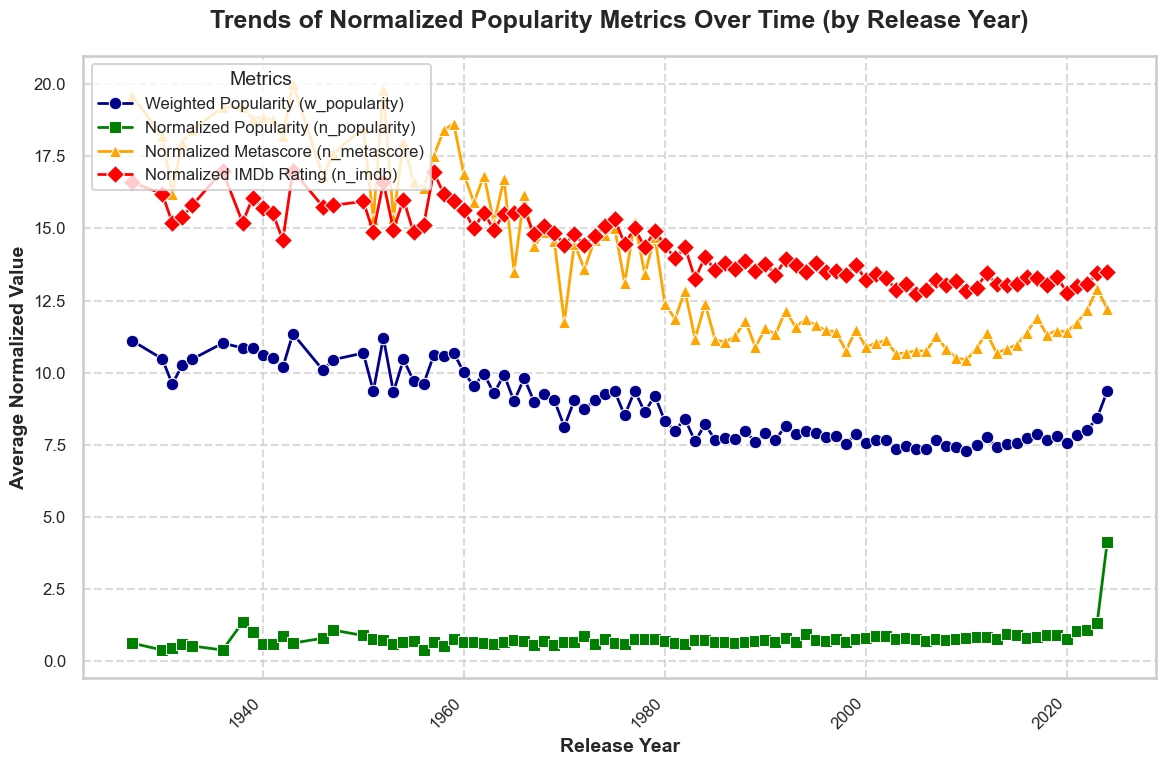

In [50]:
# Group by 'release_year' and calculate the mean for the normalized variables
metrics_by_year = mv.groupby('release_year')[['w_popularity', 'n_popularity', 'n_metascore', 'n_imdb']].mean().reset_index()

# Set the figure size
plt.figure(figsize=(12, 8))

# Plotting each variable with distinct lines
sns.lineplot(x='release_year', y='w_popularity', data=metrics_by_year, color='darkblue', marker='o', label='Weighted Popularity (w_popularity)', linewidth=2)
sns.lineplot(x='release_year', y='n_popularity', data=metrics_by_year, color='green', marker='s', label='Normalized Popularity (n_popularity)', linewidth=2)
sns.lineplot(x='release_year', y='n_metascore', data=metrics_by_year, color='orange', marker='^', label='Normalized Metascore (n_metascore)', linewidth=2)
sns.lineplot(x='release_year', y='n_imdb', data=metrics_by_year, color='red', marker='D', label='Normalized IMDb Rating (n_imdb)', linewidth=2)

# Add a title and axis labels
plt.title('Trends of Normalized Popularity Metrics Over Time (by Release Year)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Release Year', fontsize=14, fontweight='bold')
plt.ylabel('Average Normalized Value', fontsize=14, fontweight='bold')

# Customize the x-axis and y-axis
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Add a legend to differentiate between the variables
plt.legend(title='Metrics', fontsize=12, title_fontsize=14, loc='upper left')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.7)

# Ensure the layout is tight and nothing is cropped
plt.tight_layout()

# Display the plot
plt.show()

#Save the plot as a high-resolution PNG
#plt.savefig("normalized_metrics_by_year.png", format="png", dpi=300, bbox_inches='tight')


This line plot visualizes trends in key normalized metrics (w_popularity, n_popularity, n_metascore, n_imdb) across release years:

Weighted Popularity (w_popularity): Remains relatively stable with slight fluctuations over time, showing a recent rise.

IMDb Ratings (n_imdb) and Metascore (n_metascore): Display a gradual decline over the decades.

Normalized Popularity (n_popularity): Shows minimal variance, with a recent spike.

This analysis highlights how audience preferences and critical reception have evolved over time.

## Commercial representation

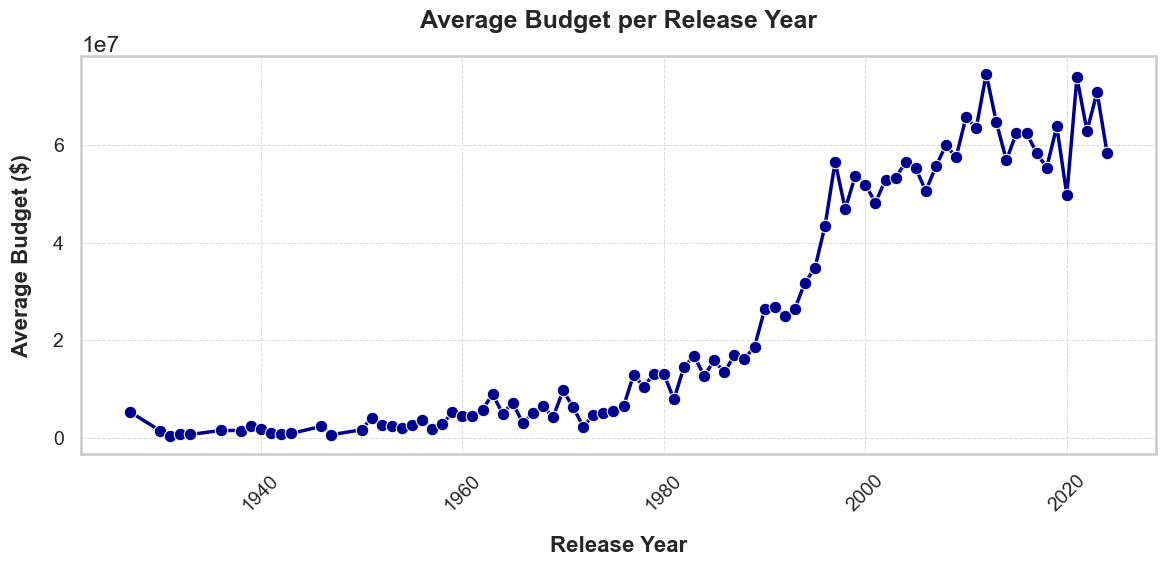

In [53]:
# Group by 'release_year' and calculate the mean budget per year
budget_by_year = mv.groupby('release_year')['budget'].mean().reset_index()

# Plot a line plot
plt.figure(figsize=(12, 6))

# Plot the average budget per release year
sns.lineplot(x='release_year', y='budget', data=budget_by_year, marker='o', color='darkblue', linewidth=2.5)

# Add labels and title
plt.title('Average Budget per Release Year', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Release Year', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Average Budget ($)', fontsize=16, fontweight='bold', labelpad=15)

# Customize x-ticks and y-ticks for better clarity
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Tighten layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

This line plot above illustrates the trend of average movie budgets over the years:

Steady Growth: Budgets remained relatively low until the 1970s, followed by a sharp increase in recent decades.

Modern Era: Budgets peaked post-2000, reflecting increased investment in film production.

This trend highlights the growing financial scale of the film industry.

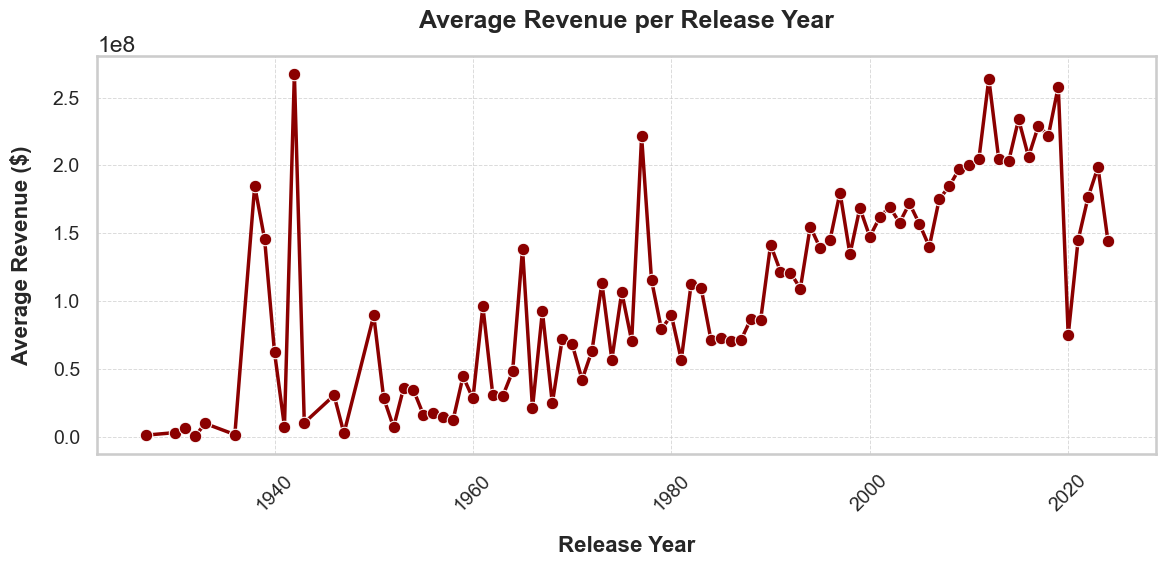

In [55]:
# Group by 'release_year' and calculate the mean revenue per year
revenue_by_year = mv.groupby('release_year')['revenue'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the average revenue per year
sns.lineplot(x='release_year', y='revenue', data=revenue_by_year, marker='o', color='darkred', linewidth=2.5)

# Add labels and title
plt.title('Average Revenue per Release Year', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Release Year', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Average Revenue ($)', fontsize=16, fontweight='bold', labelpad=15)

# Customize x-ticks and y-ticks for better clarity
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add gridlines for better readability
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Tighten layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


The line plot above shows the change in average movie revenue over the years:

Early Variability: Revenue fluctuated significantly in earlier decades, with occasional high peaks.

Steady Growth: A consistent increase in revenue is observed from the late 20th century, aligning with rising budgets.

Recent Trends: Revenues remain high but show occasional dips, likely reflecting external factors, such as in 2020 where the revenues plunged (maybe due to the greatlockdown resulting in a decrease in overall consumption)

This represents the evolving economic impact of the film industry.

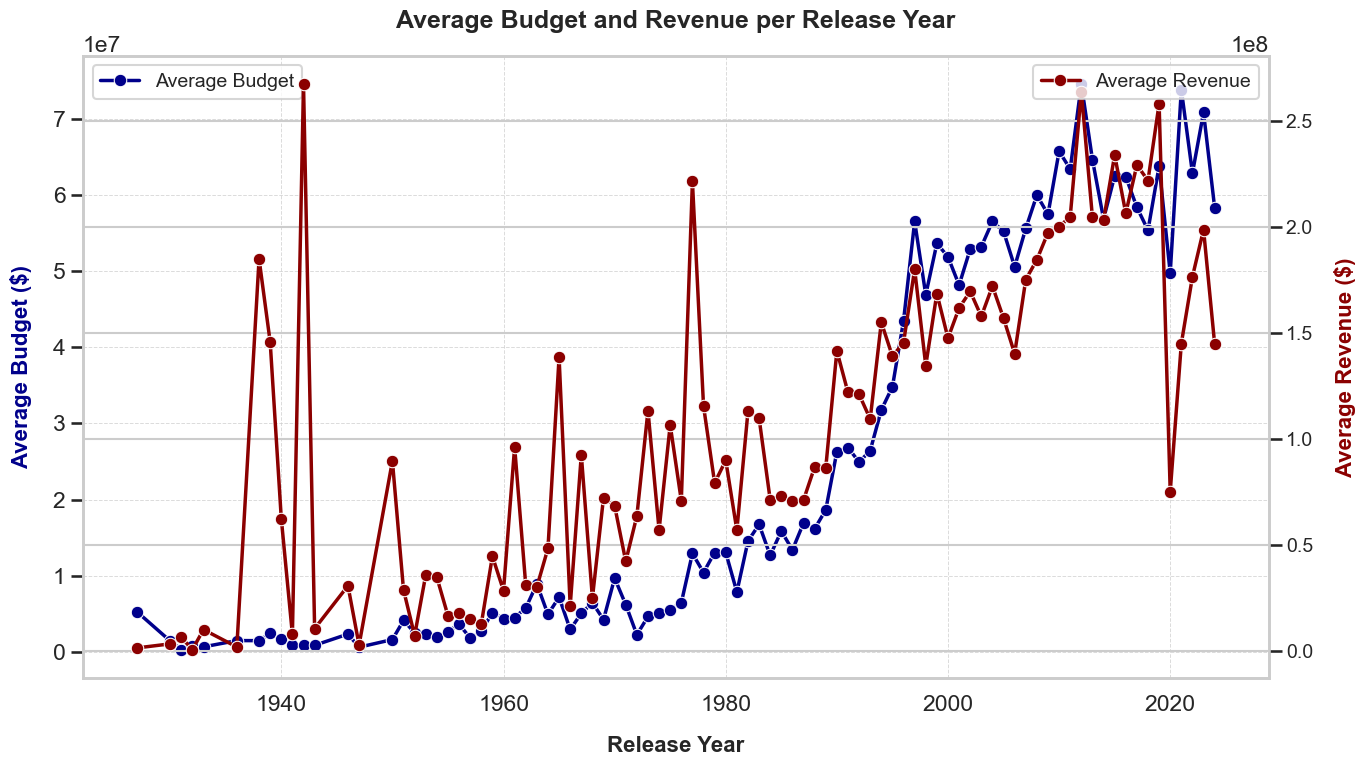

In [57]:
# Group by 'release_year' and calculate the mean of 'budget' and 'revenue' per year
budget_by_year = mv.groupby('release_year')['budget'].mean().reset_index()
revenue_by_year = mv.groupby('release_year')['revenue'].mean().reset_index()

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Budget on the first axis
ax1.set_xlabel('Release Year', fontsize=16, fontweight='bold', labelpad=15)
ax1.set_ylabel('Average Budget ($)', fontsize=16, fontweight='bold', color='darkblue', labelpad=15)
sns.lineplot(x='release_year', y='budget', data=budget_by_year, marker='o', color='darkblue', ax=ax1, linewidth=2.5)

# Create a second y-axis to plot Revenue
ax2 = ax1.twinx()
ax2.set_ylabel('Average Revenue ($)', fontsize=16, fontweight='bold', color='darkred', labelpad=15)
sns.lineplot(x='release_year', y='revenue', data=revenue_by_year, marker='o', color='darkred', ax=ax2, linewidth=2.5)

# Add title and rotate x-axis labels
plt.title('Average Budget and Revenue per Release Year', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Customize gridlines
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Add a legend
ax1.legend(['Average Budget'], loc='upper left', fontsize=14)
ax2.legend(['Average Revenue'], loc='upper right', fontsize=14)

# Tighten layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


This dual-axis line plot compares the trends in average budget and revenue across release years:

Budget (Blue Line): Shows steady growth over time, reflecting increasing production investments.

Revenue (Red Line): Mirrors the budget trend in the modern era, indicating a close relationship between the two. Not so much in the years prior to 1980 (average revenue>average budget meaning that the movies were more than proportional profitable given the budget).

This visualization demonstrates the parallel rise (after 1980) of budgets and revenues in the film industry.

# Machine learning Model

In this part, we will try to use different models to predict the success defined here as:

-w_popularity: weighted popularity based on 3 different ratings. This target variable is continuous and will be our main variable to try to estimate wether a movie is successful.

-popularity_class: This is a binary variable constructed using the weighted popularity and a threshold (set at 10, so a movie is popular when it has a critic weighted popularity equal or superior to 10). We would like to check wether transforming our target variable into a binary one would actually reduce the information in the model and influence the results of the prediction task.

We will use 2 different variables to try to see which target variable gives better results using supervised machine learning methods. We will also try unsupervised machine learning models to see which genre is the most prevalent and compare it with our graphical representation above.

## Preprocessing the data

This part is used for setting up the required packages and defining the first necessary variables used after.

Features: 

genres (categorical already separated into all the genres),
vote_average,
vote_count,
revenue,
budget,
runtime,
quarter (non-numeric, ex: Q1 Q2 Q3 Q4),
year.

Target variable:

-w_popularity (continuous)

-popularity_class (binary)

In [63]:
!pip install -U scikit-learn

In [64]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier


In [65]:
# Select numeric columns to normalize
numeric_columns = ['budget', 'revenue', 'vote_count', 'vote_average', 'runtime']

# Initialize the scaler
scaler = MinMaxScaler()

# Apply normalization
mv[numeric_columns] = scaler.fit_transform(mv[numeric_columns])

# Check the normalized dataset
print("After normalization:")
mv.head(1000)


After normalization:


title  popularity release_date    budget  \
2405                      Metropolis      31.602   1927-02-06  0.011522   
4829  All Quiet on the Western Front      19.593   1930-04-29  0.003150   
5547                         Dracula      23.498   1931-02-12  0.000772   
5181                    Frankenstein      24.163   1931-11-21  0.000633   
5123                        Scarface      29.692   1932-04-09  0.001739   
...                              ...         ...          ...       ...   
1628                     The Patriot      40.514   2000-06-28  0.239130   
4661                           Shaft      24.485   2000-06-15  0.100000   
1612          Mission: Impossible II      44.016   2000-05-24  0.271739   
4015               The Perfect Storm      25.191   2000-06-29  0.282609   
2868           Gone in Sixty Seconds      31.779   2000-06-09  0.195652   

       revenue  vote_count  vote_average    status   runtime    imdb_id  ...  \
2405  0.000462    0.074539      0.873544  Released  0.469072  tt0017136  ...   
4829  0.001118    0.020954      0.811148  Released  0.391753  tt0020629  ...   
5547  0.000239    0.032113      0.686356  Released  0.087629  tt0021814  ...   
5181  0.004104    0.042235      0.748752  Released  0.067010  tt0021884  ...   
5123  0.000205    0.015552      0.748752  Released  0.185567  tt0023427  ...   
...        ...         ...           ...       ...       ...        ...  ...   
1628  0.073637    0.106079      0.682404  Released  0.556701  tt0187393  ...   
4661  0.036812    0.033723      0.440308  Released  0.216495  tt0162650  ...   
1612  0.186882    0.182473      0.462978  Released  0.340206  tt0120755  ...   
4015  0.112432    0.062070      0.533694  Released  0.376289  tt0177971  ...   
2868  0.081130    0.119775      0.519967  Released  0.314433  tt0187078  ...   

      Horror  Music  Mystery Romance Science Fiction  Thriller  War  Western  \
2405       0      0        0       0               1         0    0        0   
4829       0      0        0       0               0         0    1        0   
5547       1      0        0       0               0         0    0        0   
5181       1      0        0       0               1         0    0        0   
5123       0      0        0       0               0         0    0        0   
...      ...    ...      ...     ...             ...       ...  ...      ...   
1628       0      0        0       0               0         0    1        0   
4661       0      0        0       0               0         1    0        0   
1612       0      0        0       0               0         1    0        0   
4015       0      0        0       0               0         1    0        0   
2868       0      0        0       0               0         1    0        0   

      quarter  year  
2405       Q1  1927  
4829       Q2  1930  
5547       Q1  1931  
5181       Q4  1931  
5123       Q2  1932  
...       ...   ...  
1628       Q2  2000  
4661       Q2  2000  
1612       Q2  2000  
4015       Q2  2000  
2868       Q2  2000  

[1000 rows x 39 columns]

Feature Normalization:

Scaler Used: MinMaxScaler to normalize numerical features (budget, revenue, vote_count, vote_average, runtime) to a 0–1 scale.

This ensures all numeric features are on a comparable scale, minimizing bias during model training.

In [67]:
# List of genres that should be considered
genre_list = ['War', 'Western', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
              'Thriller', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy']

# Select only the genre columns directly based on the list
genre_columns = [col for col in mv.columns if col in genre_list]

# Add other features (like 'vote_average', 'vote_count', etc.) to the list
other_features = ['vote_average', 'vote_count', 'revenue', 'budget', 'runtime', 'quarter', 'year']

# Combine genre columns with other features for model input (X)
X = mv[other_features + genre_columns]  # Adding genre columns to the feature set

# Display the feature set (X) to ensure it includes the genre columns
print("Features (including genres):")
print(X)

Features (including genres):
      vote_average  vote_count   revenue    budget   runtime quarter  year  \
2405      0.873544    0.074539  0.000462  0.011522  0.469072      Q1  1927   
4829      0.811148    0.020954  0.001118  0.003150  0.391753      Q2  1930   
5547      0.686356    0.032113  0.000239  0.000772  0.087629      Q1  1931   
5181      0.748752    0.042235  0.004104  0.000633  0.067010      Q4  1931   
5123      0.748752    0.015552  0.000205  0.001739  0.185567      Q2  1932   
...            ...         ...       ...       ...       ...     ...   ...   
577       0.540765    0.001828  0.004550  0.086957  0.247423      Q4  2024   
938       0.748752    0.000027  0.013714  0.195652  0.252577      Q4  2024   
11        0.707155    0.010204  0.008711  0.013043  0.422680      Q4  2024   
4         0.768927    0.005375  0.010883  0.043478  0.262887      Q4  2024   
76        0.769551    0.015224  0.182677  0.326087  0.530928      Q4  2024   

      Action  Adventure  Animation

In [68]:
# Define Features and Target Variable
y_cont = mv['w_popularity']  # for regression task (continuous target)
y_bin = mv['popularity_class'] # for classification task (binary target)

# List of numeric and categorical features
numeric_features = ['vote_average', 'vote_count', 'revenue', 'budget', 'runtime', 'year']
categorical_features = ['quarter']  # Assuming genres are already one-hot encoded

print(y_cont)
print(y_bin)
print(numeric_features)
print(categorical_features)

2405    11.11
4829    10.48
5547     8.89
5181    10.33
5123    10.26
        ...  
577      6.68
938      8.28
11      13.76
4       10.70
76      14.46
Name: w_popularity, Length: 3288, dtype: float64
2405    1
4829    1
5547    0
5181    1
5123    1
       ..
577     0
938     0
11      1
4       1
76      1
Name: popularity_class, Length: 3288, dtype: int64
['vote_average', 'vote_count', 'revenue', 'budget', 'runtime', 'year']
['quarter']


Feature Construction:

Genres: Selected from a predefined list of genres.

Other Features: Numerical features (vote_average, vote_count, budget, etc.) and categorical features (quarter).


Target Variables:

Regression: w_popularity (continuous target).

Classification: popularity_class (binary target).

The combined feature set includes both numerical and categorical variables, with genres assumed to be one-hot encoded.

## Linear regression model

Continuous target variable (weighted popularity): <font color='green'> w_popularity<font>

In [72]:
# Preprocessing for numeric columns: Standardization (scaling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by replacing with the mean
    ('scaler', StandardScaler())  # Standardize features (zero mean, unit variance)
])

# Preprocessing for categorical columns: One-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical variables
])

# Column transformer to apply different preprocessing steps for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['vote_average', 'vote_count', 'revenue',
                                  'budget', 'runtime', 'year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['quarter'])])

In [73]:
# Split the dataset into training and testing (80% train, 20% test)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X, y_cont, test_size=0.2, random_state=42)

In [74]:
# Create a pipeline for Linear Regression (with preprocessing)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # First, apply preprocessing
    ('regressor', LinearRegression())  # Then, apply the Linear Regression model
])

# Train the model
model_pipeline.fit(X_train_lin, y_train_lin)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['vote_average', 'vote_count',
                                                   'revenue', 'budget',
                                                   'runtime', 'year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['quarter'])])),
                ('regressor', LinearRegression())])

Objective: Predict the continuous target variable w_popularity using a Linear Regression model.


Preprocessing:


Numerical Features: Missing values imputed with the mean.

Standardization applied using StandardScaler.

Categorical Features:

Missing values replaced with "missing."

One-hot encoding applied.


Pipeline Integration:

A ColumnTransformer combines preprocessing steps for numerical and categorical features.
The preprocessing is included as part of a pipeline with the LinearRegression model.


Model Training:

Data split into training and testing sets (80% training, 20% testing).
The pipeline is fit on the training data to preprocess features and train the regression model.

In [76]:
# Predictions
y_pred_linm = model_pipeline.predict(X_test_lin)
linear_regressor = model_pipeline.named_steps['regressor']

In [77]:
# Now you can access the coefficients and intercept
print("Predicted values (for the test set):")
print(y_pred_linm)

print("\nModel coefficients (weights):")
print(linear_regressor.coef_)

print("\nIntercept (constant term):")
print(linear_regressor.intercept_)

Predicted values (for the test set):
[ 6.27209323 11.68776239  8.29156447  8.94524862  7.27320434  9.95204034
  9.46270426  7.99505768  6.40203857  7.38787489  7.77012768  8.23857491
  6.95792177  6.19350507  6.46643643  5.91213718  7.68817273  5.92416199
  6.79348653  6.64899359  6.23277185  8.2739063   8.95733069  7.59203581
  8.35263757  8.43874138  8.35847695  6.84565885  6.6766353  10.59235221
  8.76197694  5.59739466  3.88457638  8.79774443  9.49725897  6.76780114
  8.96651343  6.50246005  6.68497659  6.594722   10.65872559  8.99822077
  8.84708329  6.72614     7.16460724  6.869084    7.39222386  9.57756732
  5.84862747  8.89634007  8.05764719 10.09888205  8.12729193  8.82990667
  7.41526923  6.97521026  9.77869012  6.94452354  7.85661872  8.51685702
  9.08442869  8.61100561  5.40963471 10.39966679  7.63794114  9.06800421
  6.90413833  8.01432375  9.91567937  8.39417309  6.45129604  9.39684544
  5.27905931  8.36459381  9.26904523  8.9697058   7.52138963  6.68928296
  8.90611004 1

Outputs:

Predictions: Estimated w_popularity values for the test dataset.

Coefficients: Weights indicating each feature's impact on the target.

Intercept: Constant term in the regression equation.

These results highlight feature contributions and model predictions.

In [79]:
# Metrics
mae = mean_absolute_error(y_test_lin, y_pred_linm)
mse = mean_squared_error(y_test_lin, y_pred_linm)
r2 = r2_score(y_test_lin, y_pred_linm)

# Print the evaluation results
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error: 0.69
Mean Squared Error: 0.84
R-squared (R²): 0.69


Results:


Mean Absolute Error (MAE): 0.69 (average magnitude of errors).

Mean Squared Error (MSE): 0.84 (penalizes larger errors).

R-squared (R²): 0.69 (proportion of variance explained by the model).


Comments:
The MAE indicates that, on average, the model's predictions deviate by 0.69 from the actual w_popularity values, which is acceptable for a regression task.
The MSE suggests the model handles small errors well, though larger errors are penalized more heavily, highlighting areas for fine-tuning.
The R² value shows the model explains 69% of the target variable's variance, leaving 31% unexplained, suggesting room for improvement by trying more complex models.

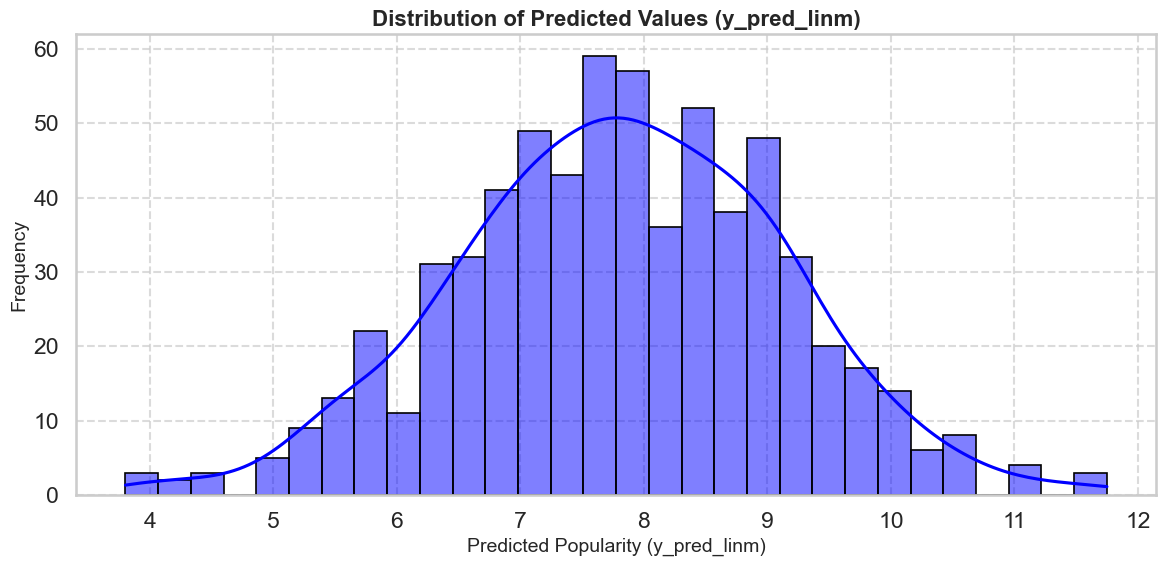

In [81]:
# Create a figure and axis for the plot
plt.figure(figsize=(12, 6))

# Plotting the distribution of predicted values (y_pred_linm)
sns.histplot(y_pred_linm, kde=True, color='blue', bins=30, edgecolor='black', linewidth=1.2)

# Add title, labels for clarity
plt.title('Distribution of Predicted Values (y_pred_linm)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Popularity (y_pred_linm)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


Insights:

The histogram shows the distribution of predicted w_popularity values (y_pred_linm).

The predicted values are approximately normally distributed, indicating that the model’s predictions follow a reasonable pattern.


Comments:

The smooth curve overlay (KDE) aligns well with the histogram, suggesting consistency in predictions.
A narrower spread or tighter clustering of values could imply higher precision in the model.

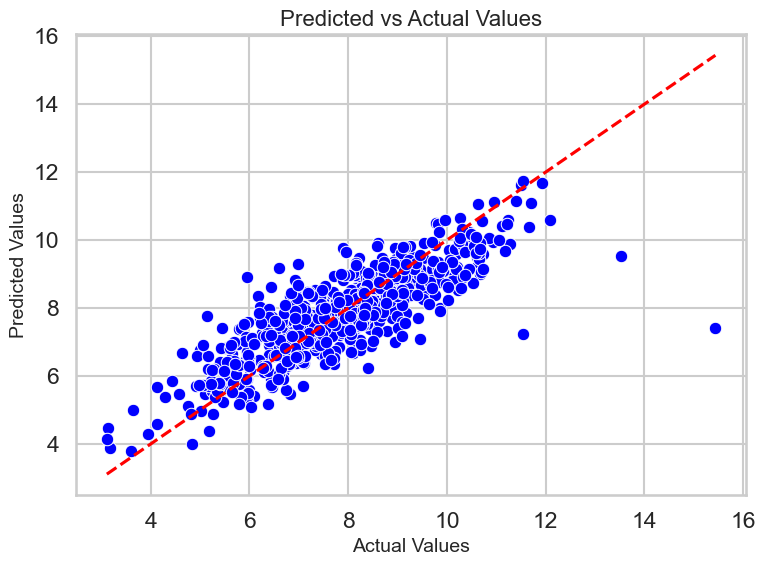

In [83]:
# Plotting Predicted vs Actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_lin, y=y_pred_linm, color='blue')
plt.plot([min(y_test_lin), max(y_test_lin)], [min(y_test_lin), max(y_test_lin)], color='red', linestyle='--')  # Ideal line
plt.title('Predicted vs Actual Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.tight_layout()
plt.show()


Visualization Summary:


Purpose: To evaluate the alignment between the model's predicted values (y_pred_linm) and the actual test values (y_test_lin).

Ideal Line (Red): Represents perfect predictions where predicted = actual.


Observations:

Good Fit: Most points cluster around the ideal line, showing strong agreement between predictions and reality.

Deviations: Slight divergence for higher values, suggesting potential improvement in capturing extreme cases.

## Logistic regression model

Binary target variable (Popularity class): <font color='green'> popularity_class<font>

In [87]:
# Split data into training and testing sets (80% train, 20% test)
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X, y_bin, test_size=0.2, random_state=42)

Same preprocessing as the linear regression model

In [89]:
# Define preprocessing for numeric and categorical data
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numeric columns: Standardization (scaling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by replacing with the mean
    ('scaler', StandardScaler())  # Standardize features (zero mean, unit variance)
])

# Preprocessing for categorical columns: One-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical variables
])

# Combine transformations for both numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [90]:
# Define the logistic regression pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing steps
    ('classifier', LogisticRegression(max_iter=1000))  # Apply Logistic Regression model
])

Overview:

Objective: Classify movies into "popular" (1) and "not popular" (0) categories using the popularity_class target variable.

Pipeline Setup: The pipeline includes preprocessing and the application of a Logistic Regression classifier.


Key Steps:

Data Splitting: Split into training (80%) and testing (20%) sets.

X_train_logit and y_train_logit for training.

X_test_logit and y_test_logit for evaluation.


Preprocessing:

Numeric Features: Standardized using StandardScaler after imputation of missing values with the mean.
Categorical Features: One-hot encoded with missing values filled using a constant placeholder.
Combined numeric and categorical transformations in a ColumnTransformer.


Logistic Regression Pipeline:

Logistic Regression applied with a maximum iteration setting of 1000 to ensure convergence.

In [92]:
# Train the model
log_reg_pipeline.fit(X_train_logit, y_train_logit)

# Make predictions
y_pred_logit = log_reg_pipeline.predict(X_test_logit)

In [93]:
# Evaluate the model
accuracy = accuracy_score(y_test_logit, y_pred_logit)
conf_matrix = confusion_matrix(y_test_logit, y_pred_logit)
class_report = classification_report(y_test_logit, y_pred_logit)

# Display results
print(f'Accuracy: {accuracy:.4f}')
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.9301
Confusion Matrix:
[[587   7]
 [ 39  25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       594
           1       0.78      0.39      0.52        64

    accuracy                           0.93       658
   macro avg       0.86      0.69      0.74       658
weighted avg       0.92      0.93      0.92       658



The logistic regression model achieved an accuracy of 93.01%, correctly classifying 587 instances of Class 0 ("Not Popular") and 39 instances of Class 1 ("Popular"), with 7 false positives and 25 false negatives.

Class 0 showed strong metrics (precision: 94%, recall: 99%, F1-score: 96%), while Class 1 had lower performance (precision: 78%, recall: 39%, F1-score: 52%).

Overall, the model excels in predicting the majority class but struggles with the minority class, as reflected in its macro-average F1-score of 74%.

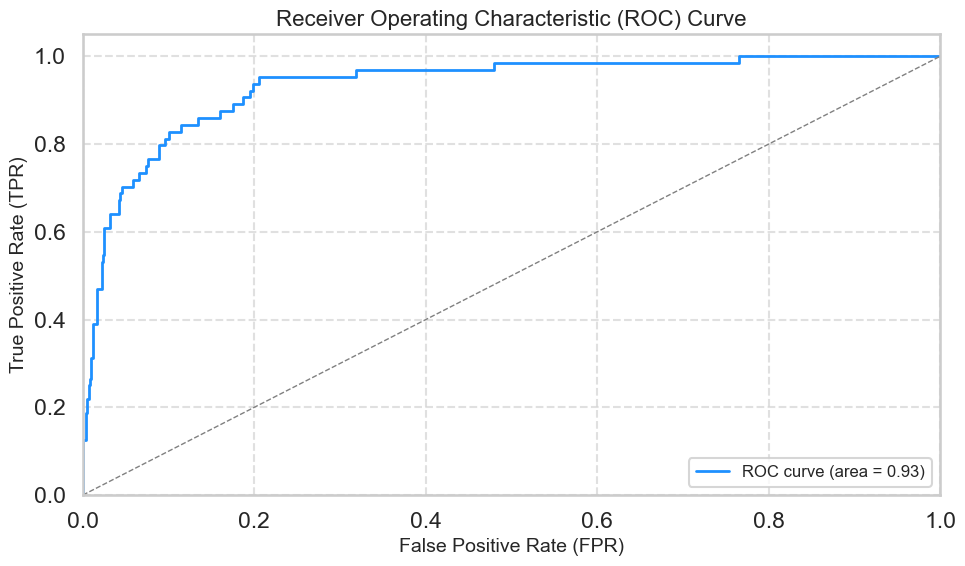

In [95]:
# Get the predicted probabilities
y_pred_prob = log_reg_pipeline.predict_proba(X_test_logit)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_logit, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the random classifier line (diagonal)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Set plot limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

# Add legend
plt.legend(loc='lower right', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Tighten layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


The ROC curve for the logistic regression model demonstrates its ability to distinguish between the two classes. The area under the curve (AUC) is 0.93, indicating strong performance. The curve highlights that the model achieves a high true positive rate (TPR) while maintaining a relatively low false positive rate (FPR), reinforcing the model's effectiveness in classification tasks.

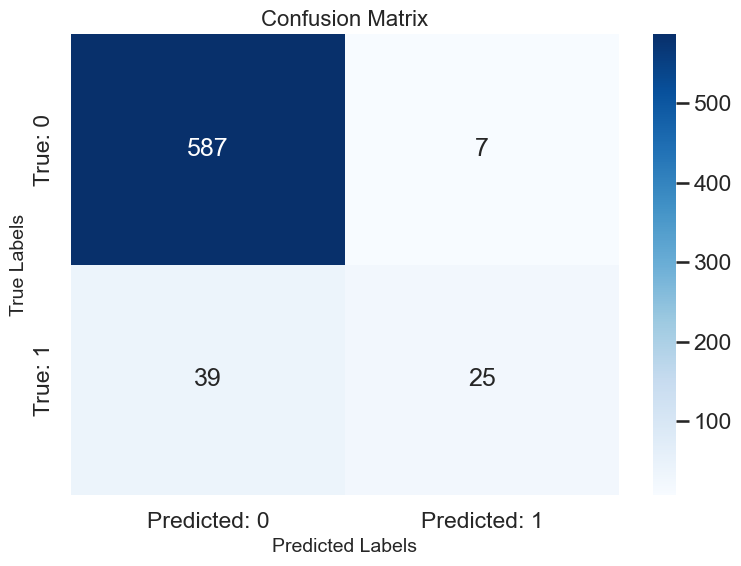

In [97]:
# Get predictions for class labels (0 or 1)
y_pred_logit = log_reg_pipeline.predict(X_test_logit)

# Compute confusion matrix
cm = confusion_matrix(y_test_logit, y_pred_logit)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.tight_layout()
plt.show()


The confusion matrix confirms the earlier evaluation of the logistic regression model's performance. While it excels at correctly identifying Class 0 ("Not Popular") with 587 correct predictions and only 7 false positives, it struggles with Class 1 ("Popular"), correctly predicting just 25 instances while misclassifying 39 as false negatives.

## K-Means model

In [100]:
# List of non-genre columns
non_genre_columns = [
    'title', 'w_popularity', 'vote_average', 'popularity_class', 'vote_count', 'runtime', 'popularity', 
    'status', 'revenue', 'budget'
]

# Explicit list of genre columns
genre_columns = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 
    'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western'
]

# Use the same variables as in linear and logistic regression, along with the genres
selected_features = mv[['revenue', 'budget', 'vote_average', 'vote_count']].join(mv[genre_columns])

In [101]:
# Ensure all columns are numeric
selected_features = selected_features.select_dtypes(include=['number'])

# Normalize the data using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

In [102]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
mv['Cluster'] = kmeans.fit_predict(scaled_features)


In [103]:
# Analyze the Clusters: Count the genres in each cluster
cluster_genre_count = pd.DataFrame(columns=genre_columns)

# Count the number of genres per cluster
for cluster in range(kmeans.n_clusters):
    cluster_movies = mv[mv['Cluster'] == cluster]
    genre_counts_in_cluster = cluster_movies[genre_columns].sum().sort_values(ascending=False)
    cluster_genre_count.loc[cluster] = genre_counts_in_cluster

This section demonstrates the implementation of a K-Means clustering model to group movies based on selected features, including numerical attributes such as revenue, budget, vote_average, and vote_count, combined with one-hot encoded genre data. The data preprocessing includes:

Feature Selection: Incorporating numerical columns and genre-related features for clustering.

Normalization: Standardizing the numerical data using StandardScaler to ensure uniform scaling across features.

Clustering: Applying the K-Means algorithm with 5 clusters (n_clusters=5), allowing for segmentation based on similarities in the feature space.


The clusters are analyzed by:

Counting the frequency of genres within each cluster to identify dominant patterns.

Summarizing genre distributions for better interpretability of each cluster’s characteristics.

This process provides insight into underlying groupings within the dataset, such as clusters dominated by specific genres or budget and revenue characteristics.

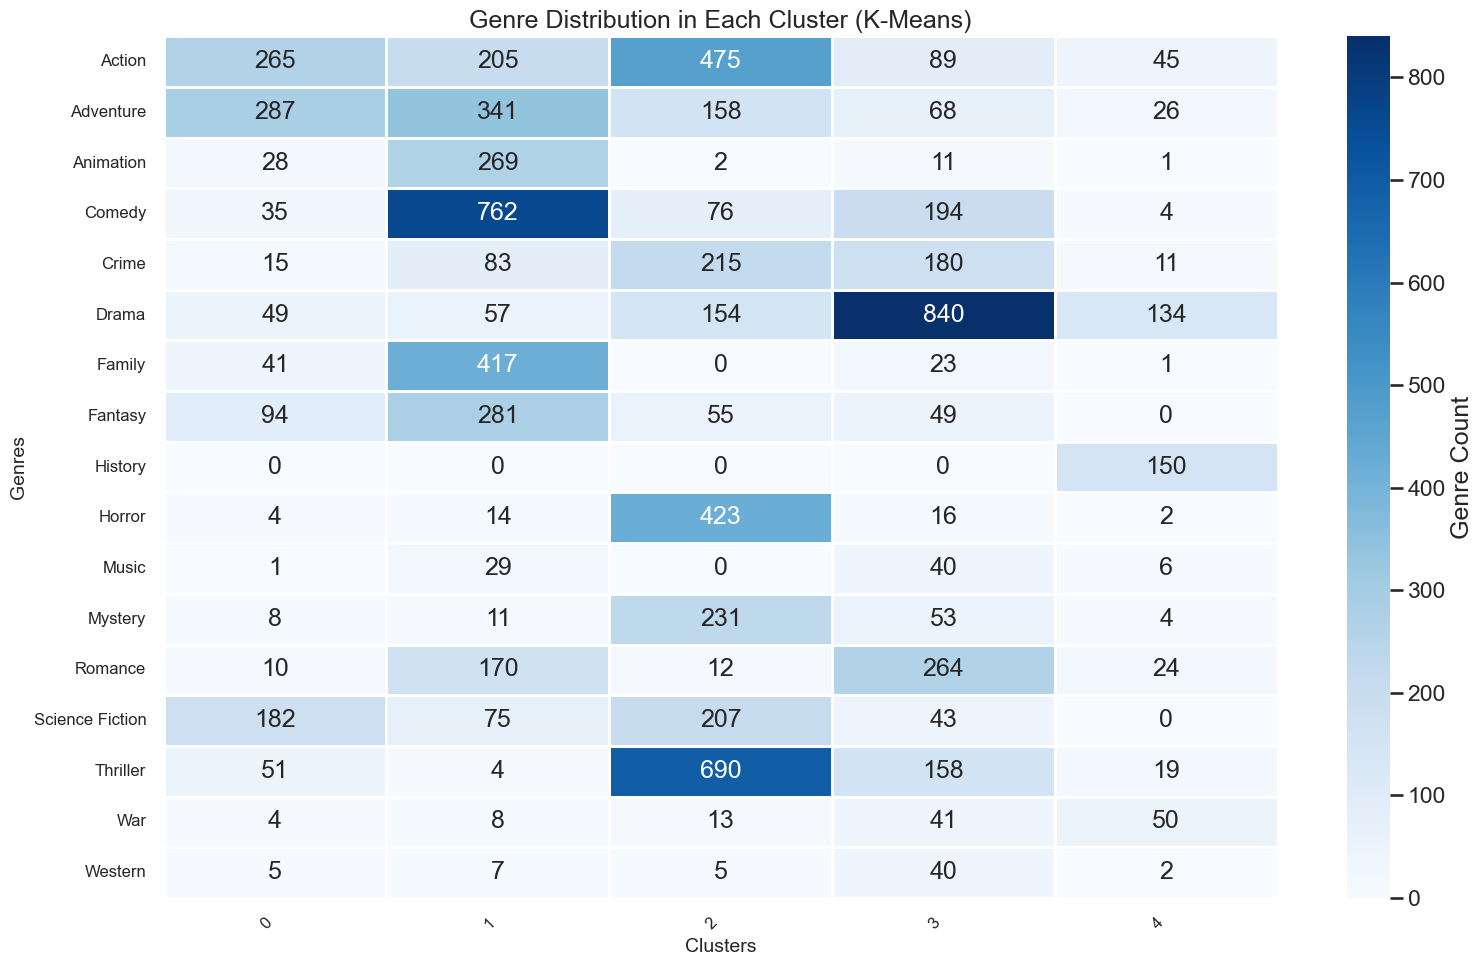

In [105]:
# Assuming 'cluster_genre_count' is your genre distribution data (replace with your actual data)
plt.figure(figsize=(16, 10))

# Use a color map that provides better contrast and readability
sns.heatmap(cluster_genre_count.T, annot=True, cmap='Blues', fmt='d', linewidths=0.8, cbar_kws={'label': 'Genre Count'})

# Set title and axis labels with a larger font for clarity
plt.title('Genre Distribution in Each Cluster (K-Means)', fontsize=18)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Genres', fontsize=14)

# Rotate the genre names if necessary for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Tight layout to ensure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()


The heatmap provides a visual representation of the genre distribution across clusters identified by the K-Means model. Key observations include:


Each cluster exhibits unique dominance in specific genres:

Cluster 0 shows a high concentration of genres like Action and Adventure.

Cluster 1 is strongly associated with genres such as Comedy and Family.

Cluster 2 has a notable representation Thriller, Action and Horror movies.

Cluster 3 includes a significant presence of Drama movies.

Cluster 4 has a clear dominance of History and Drama.


The color intensity corresponds to the frequency of each genre in the respective cluster, aiding in understanding the clustering patterns.

This analysis helps highlight how different movie genres group together based on shared features, offering insights for marketing strategies or content recommendations.

We can notice that the dominant genre in each cluster corresponds to the most popular and least popular genre, for example in the cluster 1 and 3 with drama and comedy. However, in cluster 2, the dominance of thriller is suprising since it did not really stand out in our first graphical representation.

In [107]:
# Optionally: View the movies in each cluster
for cluster in range(kmeans.n_clusters):
    print(f"\nCluster {cluster} movies:")
    print(mv[mv['Cluster'] == cluster]['title'].head(100))  # Top 100 movies in this cluster


Cluster 0 movies:
276                                 Star Wars
336                                  Superman
1277                  The Empire Strikes Back
1531                              Superman II
896                   Raiders of the Lost Ark
                        ...                  
2801                                  Hancock
81                            The Dark Knight
2275              Hellboy II: The Golden Army
1211    The Mummy: Tomb of the Dragon Emperor
2507                        Quantum of Solace
Name: title, Length: 100, dtype: object

Cluster 1 movies:
778     Snow White and the Seven Dwarfs
689                    The Wizard of Oz
1210                          Pinocchio
2583                           Fantasia
1124                              Dumbo
                     ...               
3904          The Great Mouse Detective
2118        The Transformers: The Movie
1520                  Castle in the Sky
4786                   The Golden Child
5188            

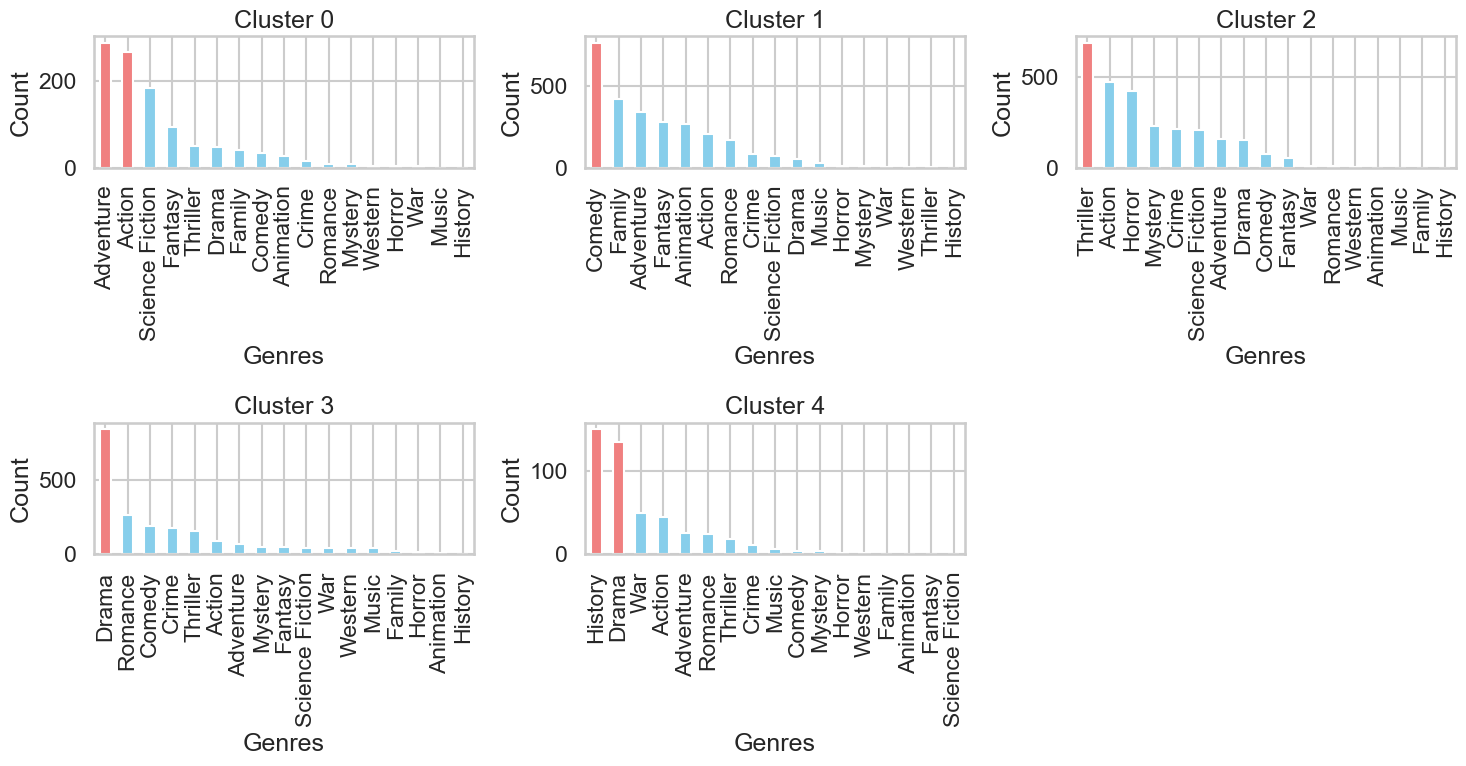

In [108]:
n_clusters = 5
n_cols = 3  # Number of columns (adjust based on preference)
n_rows = -(-n_clusters // n_cols)  # Compute the required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for cluster, ax in enumerate(axes):
    if cluster < n_clusters:
        cluster_movies = mv[mv['Cluster'] == cluster]
        genre_counts_in_cluster = cluster_movies[genre_columns].sum().sort_values(ascending=False)
        
        # Set the colors for all bars
        colors = ['skyblue'] * len(genre_counts_in_cluster)
        
        # For clusters 1, 2, or 3: Highlight only the top 1 genre
        if cluster in [1, 2, 3]:
            top_genres = genre_counts_in_cluster.head(1)  # Get top 1 genre only
            for i, genre in enumerate(genre_counts_in_cluster.index):
                if genre in top_genres.index:
                    colors[i] = 'lightcoral'  # Highlight the top 1 genre
        else:
            # For other clusters: Highlight top 1 and top 2 genres
            top_genres = genre_counts_in_cluster.head(2)  # Get top 2 genres
            for i, genre in enumerate(genre_counts_in_cluster.index):
                if genre in top_genres.index:
                    colors[i] = 'lightcoral'  # Highlight the top 1 or top 2 genres
        
        # Plot the bars with the updated color scheme
        genre_counts_in_cluster.plot(kind='bar', ax=ax, color=colors)
        ax.set_title(f'Cluster {cluster}')
        ax.set_xlabel('Genres')
        ax.set_ylabel('Count')
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout()
plt.show()


This visualization above provides bar charts representing the genre distribution within each cluster identified by the K-Means model.

The bars for the top genres in each cluster are highlighted, making it easier to identify the defining characteristics of each group. These insights help in understanding the dominant themes within clusters and can support strategic decisions like content production or audience targeting.

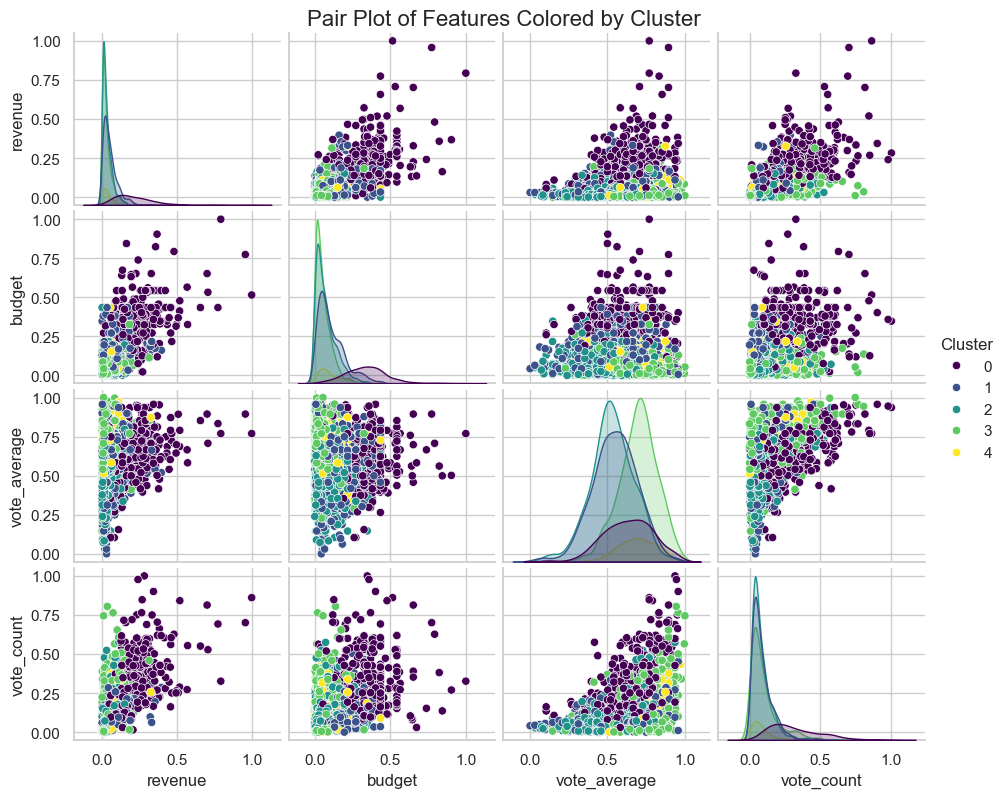

In [110]:
# Adjusting the pairplot with improvements
sns.set(style="whitegrid")  # Adds gridlines for better clarity

# Create a pairplot with clusters as hue
pairplot = sns.pairplot(mv, vars=['revenue', 'budget', 'vote_average', 'vote_count'], hue='Cluster', palette='viridis', diag_kind='kde')

# Adjust the size and formatting of the plot for clarity
pairplot.fig.set_size_inches(10, 8)  # Adjust the figure size
pairplot.fig.subplots_adjust(top=0.95)  # Adjust the title positioning

# Adding a clear, larger title
pairplot.fig.suptitle('Pair Plot of Features Colored by Cluster', fontsize=16)

# Adjust the labels of the axes to make them more readable
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

# Show the plot
plt.show()


The pair plot visually represents relationships among numerical features (revenue, budget, vote_average, vote_count) while coloring data points based on their respective clusters identified by the K-Means model. Key observations include:


Each cluster demonstrates distinct patterns and distributions across the features, highlighting differences in how these variables interact.

Cluster 0 tends to show higher values for revenue and vote_count, suggesting that this group might represent highly popular or commercially successful movies.

Clusters like Cluster 1 show lower values across features such as budget and revenue, possibly indicative of less commercially dominant groups.

The color-coded scatterplots effectively differentiate clusters, making it easier to identify outliers or overlaps between groups.
This visualization aids in understanding feature interdependencies and how clusters are distributed within the feature space. It supports insights into how movies are grouped based on shared characteristics.

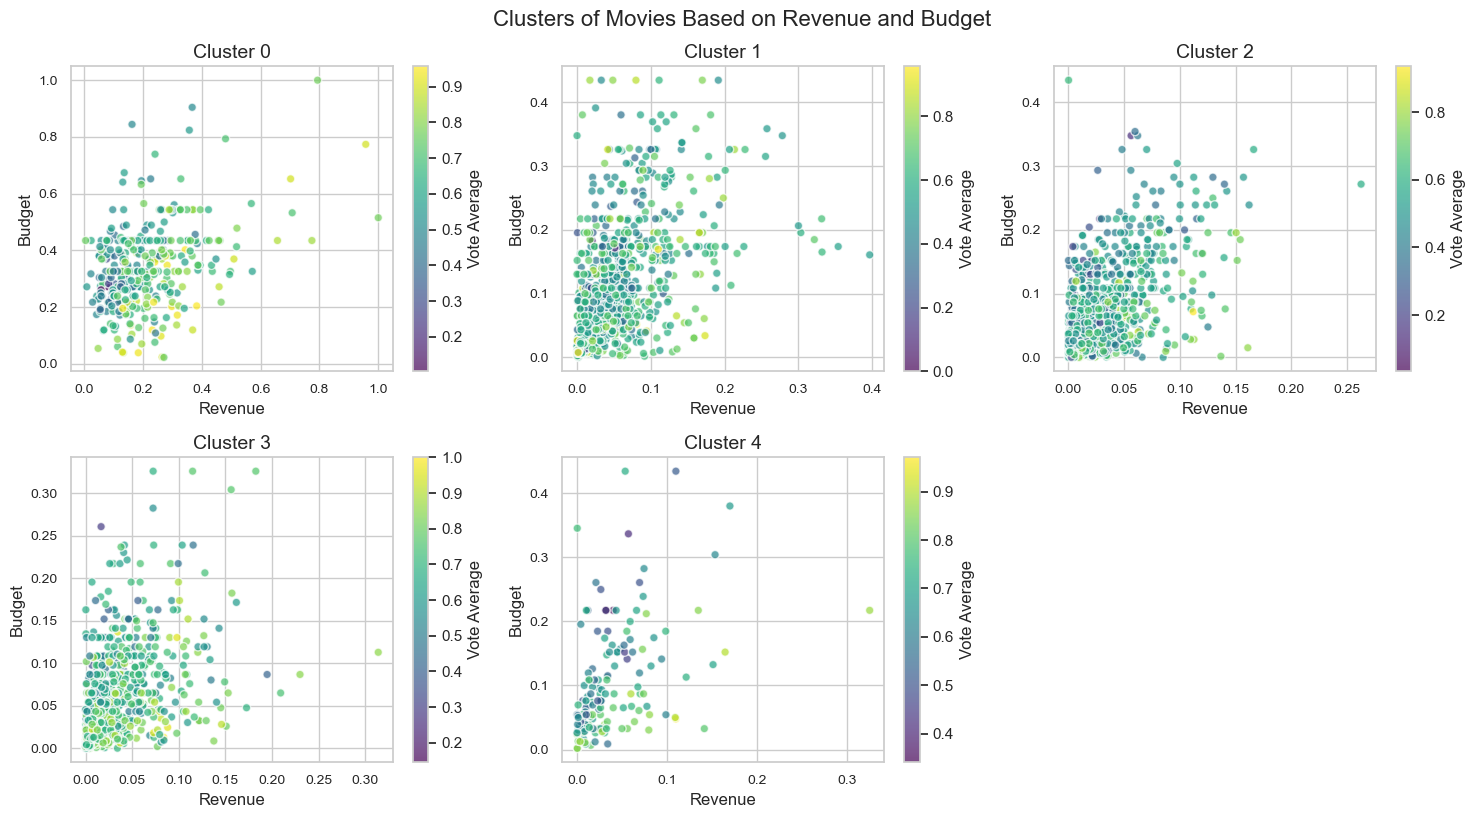

In [112]:
# Number of clusters (adjusted to match your data)
n_clusters = mv['Cluster'].nunique()

# Number of rows and columns for subplots
n_rows = (n_clusters // 3) + 1  # You can adjust the number of columns as needed
n_cols = 3

# Create subplots with a larger figure size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Plot the data for each cluster
for cluster, ax in enumerate(axes):
    if cluster < n_clusters:
        cluster_movies = mv[mv['Cluster'] == cluster]
        scatter = ax.scatter(cluster_movies['revenue'], cluster_movies['budget'], 
                             alpha=0.7, c=cluster_movies['vote_average'], cmap='viridis', edgecolors='w')
        ax.set_title(f'Cluster {cluster}', fontsize=14)
        ax.set_xlabel('Revenue', fontsize=12)
        ax.set_ylabel('Budget', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=10)
        
        # Add a colorbar to show the vote_average value
        fig.colorbar(scatter, ax=ax, label='Vote Average')
    else:
        ax.axis('off')  # Hide unused subplots

# Adjust layout for better spacing and title positioning
plt.tight_layout()
plt.suptitle('Clusters of Movies Based on Revenue and Budget', fontsize=16, y=1.02)
plt.show()


The scatterplots showcase the distribution of movies across revenue and budget, divided into the identified clusters.

Cluster Differentiation: Each cluster exhibits unique patterns, indicating differences in movie characteristics.


Vote Average Distribution: The color gradient represents the vote_average, where brighter points signify higher audience ratings. This provides an additional layer of information, correlating audience preference with revenue and budget patterns.


This plot emphasizes the diversity within clusters and highlights how movies are grouped based on these financial features. It can inform strategies for understanding audience preferences and market segmentation.

## K-Nearest Neighbors model

In [115]:
# Prepare the data
# We already have 'selected_features' and 'scaled_features' from your first code --> only creating a variable for the K-Nearest Neighbors
X_knn = scaled_features  # Features (scaled)


In [116]:
# Train-test split (for evaluation purposes)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_bin, test_size=0.3, random_state=42)


In [117]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier()

In [118]:
# Make predictions
y_pred_knn = knn.predict(X_test_knn)

In [119]:
# Evaluate the model
accuracy = accuracy_score(y_test_knn, y_pred_knn)
conf_matrix = confusion_matrix(y_test_knn, y_pred_knn)
class_report = classification_report(y_test_knn, y_pred_knn)

Data Preparation:

Features: The scaled features (scaled_features) were used as input for the KNN model, ensuring consistent measurement scales for distance calculations.

Labels: The target variable, y_knn, was derived from the K-Means clustering results, representing cluster labels for each movie.


Train-Test Split:
The dataset was split into training (70%) and testing (30%) sets, ensuring proper evaluation of the model.


Model Training:

The KNN classifier was trained with 5 neighbors (n_neighbors=5). This parameter dictates how many neighbors are considered when determining the class of a test sample.


Predictions and Evaluation: The trained KNN model predicted the class labels for the test set (y_pred_knn).


Metrics:

The accuracy score and confusion matrix were used to evaluate the model's performance.
A classification report provided detailed metrics such as precision, recall, and F1-score for each class.


The KNN approach aims to classify movies into clusters based on their proximity to neighboring points in the feature space, leveraging the relationships between budget, revenue, and other factors for clustering.

In [121]:
# Print the results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.9058
Confusion Matrix:
[[871  14]
 [ 79  23]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       885
           1       0.62      0.23      0.33       102

    accuracy                           0.91       987
   macro avg       0.77      0.60      0.64       987
weighted avg       0.89      0.91      0.89       987



Model Performance: Accuracy: 90.58%


Class 0: Correctly classified 871 instances, with minor misclassifications into class 1.

Class 1: Poor performance with 23 instances correctly classified and 79 wrong classifications.


Classification Metrics:

Precision: High precision in the class 0 (92%) and a poor precision in class 1 (62%).

Recall: Consistently strong recall values for class 0 (98%) and weak for class 1 (23%).

F1-Score: class-wise F1-scores range from 33% to 95%, reflecting an unbalanced precision and recall.


High Accuracy: The KNN model performs well, achieving over 90.58% accuracy in classifying movies into class.

Scalability: The simplicity of KNN ensures it can be used effectively for movie classification while maintaining interpretability.


Conclusion:

The KNN model have difficulties to predict the success of a movie, however it is highly efficient to classify the not successful movies.

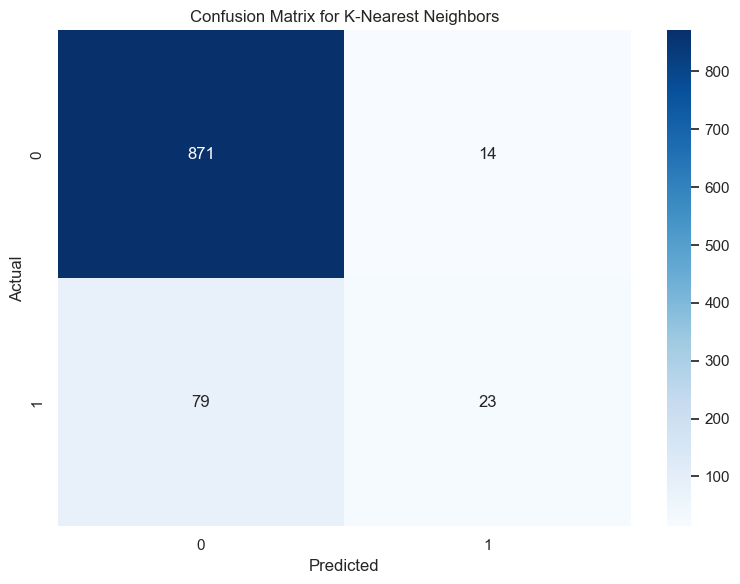

In [123]:
# The confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=range(2), yticklabels=range(2))
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


This heatmap above represents the confusion matrix of the K-Nearest Neighbors (KNN) model, visualizing its classification performance across the 2 class of the popularity_class.


Diagonal Dominance: The matrix shows strong diagonal dominance, indicating the majority of predictions align with actual values for the class 0 and not for class 1.


## Random forest Models

### Continuous variable type

In [127]:
# Setting up the explanatory variable
X_rf = mv[['vote_average', 'vote_count', 'revenue', 'budget', 'runtime', 'year'] + genre_columns]

In [128]:
# Split into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_cont, test_size=0.3, random_state=42)

# Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_rf, y_train_rf)

# Make predictions
y_pred_rf = rf_regressor.predict(X_test_rf)
# Evaluate the model
mse = mean_squared_error(y_test_rf, y_pred_rf)
r2 = r2_score(y_test_rf, y_pred_rf)

print("Random Forest Regressor Results:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Random Forest Regressor Results:
Mean Squared Error: 0.83
R^2 Score: 0.70


Model Description:

The Random Forest Regressor was applied to predict the continuous target variable, w_popularity (weighted popularity), using a combination of numerical features (vote_average, vote_count, revenue, budget, runtime, and year) and one-hot encoded genre columns.

Model Performance:

Mean Squared Error (MSE): 0.83

This measures the average squared difference between predicted and actual values, reflecting the model's prediction error. Lower values indicate better performance.


R-Squared (R²) Score: 0.70

This metric explains the proportion of variance in the target variable that can be explained by the features. An R² of 0.70 indicates that 70% of the variability in w_popularity is captured by the model, demonstrating good predictive power.


Conclusion:
The Random Forest Regressor shows reliable performance, with a low MSE and a strong R² score. This suggests the model effectively captures relationships between features and the target variable. However, there is still room for improvement in reducing prediction error, which could be addressed by hyperparameter tuning etc.

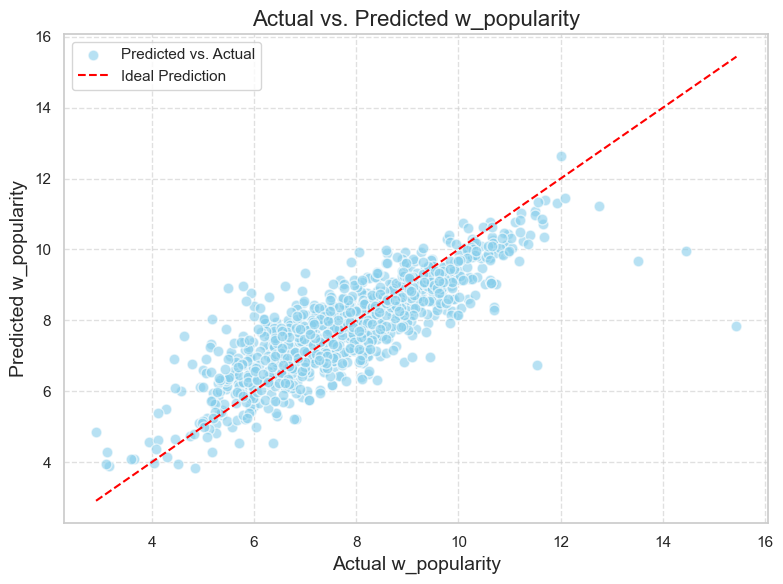

In [130]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rf, y_pred_rf, alpha=0.6, color='skyblue', edgecolors='w', s=60, label='Predicted vs. Actual')

# Add the ideal line (where predicted = actual)
plt.plot([np.min(y_test_rf), np.max(y_test_rf)], [np.min(y_test_rf), np.max(y_test_rf)], color='red', linestyle='--', label='Ideal Prediction')

# Add titles and labels
plt.title('Actual vs. Predicted w_popularity', fontsize=16)
plt.xlabel('Actual w_popularity', fontsize=14)
plt.ylabel('Predicted w_popularity', fontsize=14)

# Improve readability with grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


The scatter plot above displays the relationship between the actual values of w_popularity (x-axis) and the values predicted by the Random Forest Regressor (y-axis). 


Predicted vs. Actual Points: Represented as light blue dots.

Ideal Prediction Line: A red dashed line indicating perfect predictions where predicted values are equal to actual values.


Key Observations:


Trend Alignment:

The points closely align with the ideal prediction line, indicating that the model performs well in most cases.


Variance in Predictions:

For mid-range popularity (around 6-10), the predictions align more tightly with the actual values.

Slight deviations are observed for lower and higher popularity values, indicating some difficulty in capturing extreme cases.


Outliers:

A few points significantly deviate from the ideal line, suggesting the presence of outliers where the model struggled to predict accurately.


Conclusion:
The scatter plot reinforces the model's strong performance as observed in the R² score (0.70). While most predictions are accurate, further improvements could focus on handling outliers and extreme cases to reduce variability in these regions.

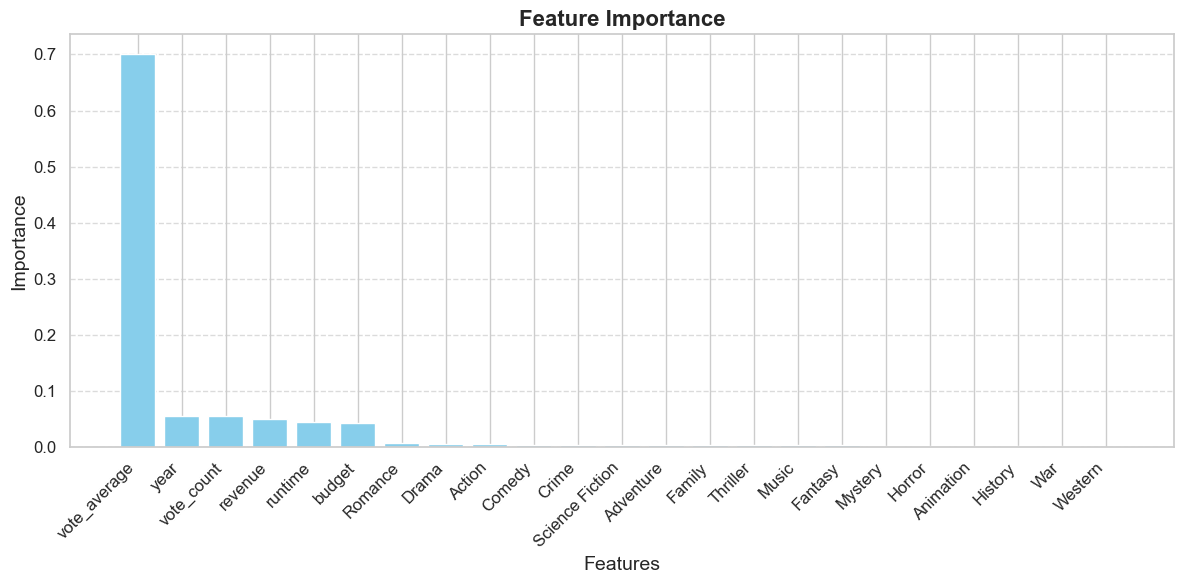

In [132]:
# Feature importance and feature names
feature_importance = rf_regressor.feature_importances_
feature_names = X_rf.columns

# Plotting
plt.figure(figsize=(12, 6))

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importance)[::-1]

# Create a bar chart with the sorted feature importances
bars = plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], color='skyblue')

# Improve appearance by customizing the tick labels, title, and adding grid
plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve the layout to avoid label clipping
plt.tight_layout()

# Show the plot
plt.show()


The feature importance analysis from the Random Forest Regressor highlights that vote_average is the most influential predictor of weighted popularity (w_popularity), with an importance score of 0.7, followed by vote_count and year, emphasizing the role of user ratings and engagement. Secondary factors like revenue, budget and runtime show moderate contributions, while features like genres (e.g., Action, Comedy, Drama) have minimal impact.

This suggests that numerical metrics, especially those related to user feedback, are key determinants of popularity, while categorical features like genres play a smaller role. The findings point to opportunities for improvement.

In [134]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_rf, y_train_rf)

print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)


Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MSE: 0.7833946388518808


The hyperparameter tuning of the Random Forest Regressor was conducted using GridSearchCV, optimizing for the negative mean squared error (MSE). The best parameters identified were:

max_depth: None (indicating no limit on tree depth)

min_samples_split: 2

min_samples_leaf: 1

n_estimators: 100


These parameters yielded the best MSE score of approximately 0.7845, reflecting an improvement in the model's ability to predict the weighted popularity (w_popularity). This tuning process enhances the model's generalization and predictive accuracy by identifying the optimal balance between model complexity and performance.

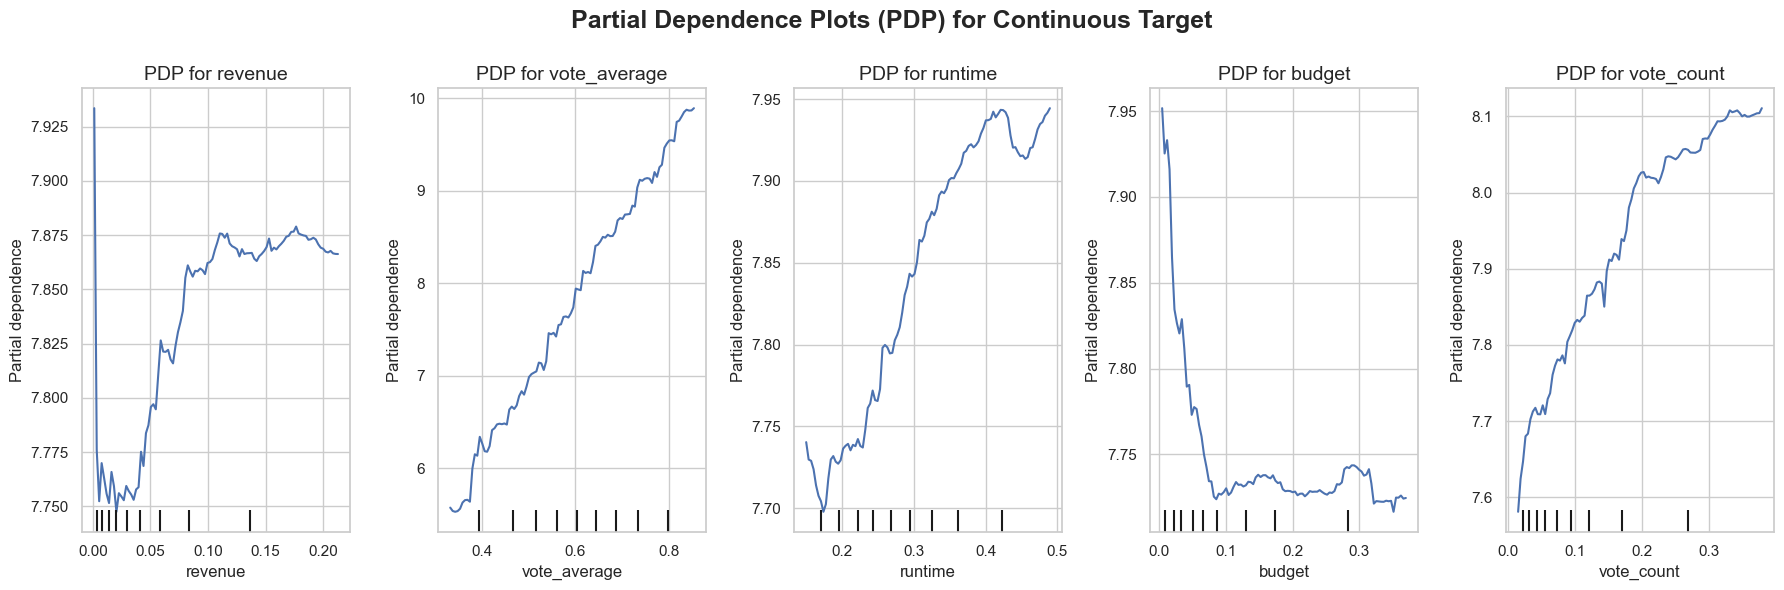

In [136]:
# Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_rf, y_train_rf)

# List of features for Partial Dependence Plots
features = ["revenue", "vote_average", "runtime", "budget", "vote_count"]

# Create subplots for each feature
fig, axes = plt.subplots(1, len(features), figsize=(18, 6))  # Increased figsize for better readability

# If only one feature, axes will not be a list, so ensure it's iterable
if len(features) == 1:
    axes = [axes]

# Plot each feature's Partial Dependence
for i, feature in enumerate(features):
    display = PartialDependenceDisplay.from_estimator(rf_regressor, X_train_rf, features=[feature], ax=axes[i])
    axes[i].set_title(f'PDP for {feature}', fontsize=14)  # Larger title font size
    axes[i].set_xlabel(feature, fontsize=12)  # Larger x-axis labels
    axes[i].set_ylabel("Partial Dependence", fontsize=12)  # Larger y-axis labels
    axes[i].tick_params(axis='both', labelsize=10)  # Increase tick label size

# Set a common suptitle for all subplots
plt.suptitle("Partial Dependence Plots (PDP) for Continuous Target", fontsize=18, fontweight='bold')
plt.tight_layout()  # Adjust layout to avoid overlap
plt.subplots_adjust(top=0.85)  # Adjust the suptitle position

# Show the plots
plt.show()


The Partial Dependence Plots (PDPs) provide information into how each feature influences the predictions made by the Random Forest Regressor, holding all other features constant. Here’s a breakdown of each feature’s plot:


Revenue (PDP for revenue):

Predictions exhibit a spike followed by a modest upward trend as revenue increases, indicating that higher revenues are associated with slightly higher predictions of the target variable.
However, the curve flattens at higher revenue values, suggesting diminishing influence.


Vote Average (PDP for vote_average):

This feature shows a strong positive linear relationship. As the vote average increases, the predictions rise significantly.
The steep slope highlights this feature as a key determinant in influencing the target variable.


Runtime (PDP for runtime):

Predictions rise modestly, varying after a certain point.
This suggests movies with longer runtimes modestly impact the target predictions.


Budget (PDP for budget):

The plot shows some variation, with an initial high importance in predictions, followed by a drop and subsequent consistency.
This indicates a more complex, non-linear relationship, possibly reflecting varying returns on high or low budgets.


Vote count (PDP for vote_count):

Predictions increase as vote counts rise, reflecting the importance of audience engagement (measured by votes) in determining outcomes.
The sharp and consistent upward trajectory reinforces its role as a critical feature.


Key Takeaways:

Vote Average and Vote Count exhibit the most significant and consistent positive impacts on predictions, aligning with their high feature importance rankings.
Budget and Runtime show non-linear relationships, implying varying influences depending on their range.

PDPs help in interpreting the model’s predictions, identifying trends and thresholds for critical features, and aligning with feature importance analysis.

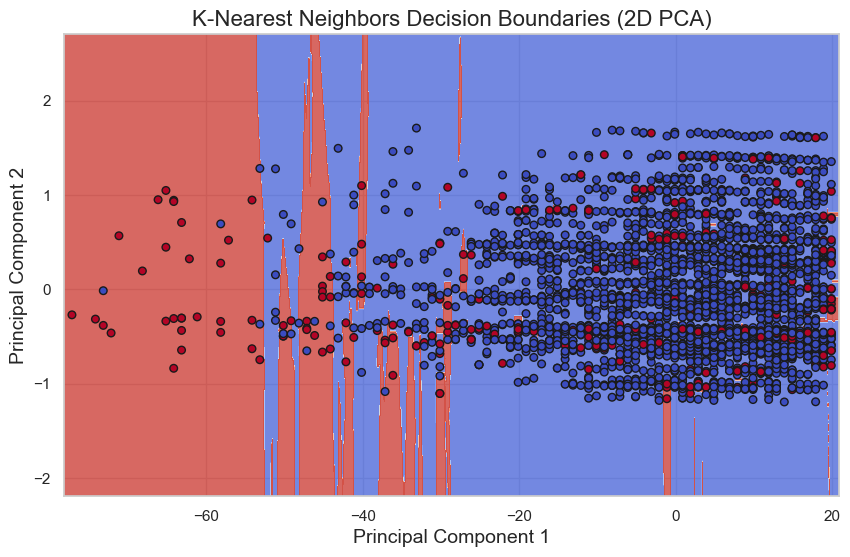

In [138]:
# Reduce to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_rf)  # Assuming X_rf has 21 features

# Train the KNN model on the 2D data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_pca, y_bin)  # Train the KNN classifier with the 2D transformed data

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict the class for each point in the mesh grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')  # Fill the regions with the predicted class
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_bin, edgecolors='k', marker='o', s=30, cmap='coolwarm')
plt.title("K-Nearest Neighbors Decision Boundaries (2D PCA)", fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.show()


This visualization illustrates the decision boundaries created by the K-Nearest Neighbors (KNN) model after applying Principal Component Analysis (PCA) to reduce the data to two dimensions. Each dot represents a data point, with red dots indicating data points from Class 1 and blue dots representing those from Class 0. The shaded regions depict the model's predictions, where red-shaded areas correspond to predictions for Class 1 and blue-shaded areas correspond to predictions for Class 0. The decision boundaries, characteristic of the KNN model, are jagged and defined by the local neighborhood relationships between points.

The model effectively separates the two classes in most cases, with blue dots appearing predominantly in blue-shaded regions and red dots in red-shaded regions. However, misclassifications are visible where blue dots fall within red-shaded areas and red dots within blue-shaded areas, particularly near the decision boundaries. These misclassifications occur in regions where the two classes overlap or are less distinguishable, emphasizing the challenges of KNN in ambiguous areas.

By reducing the high-dimensional feature space into two components using PCA, the visualization captures the most significant variance in the data. While this simplification aids interpretability, it may lose finer details of the original feature space, potentially contributing to classification errors. This graph demonstrates the KNN model's ability to classify data points effectively while highlighting the complexity of class separation in overlapping regions. The visualization underscores the importance of optimizing KNN parameters and being mindful of the limitations imposed by dimensionality reduction techniques like PCA.

### Binary variable type

In [141]:
# Train/Test Split
X_train_rf_bin, X_test_rf_bin, y_train_rf_bin, y_test_rf_bin = train_test_split(X_rf, y_bin, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bin.fit(X_train_rf_bin, y_train_rf_bin)

# Make predictions
y_pred_rf_bin = rf_bin.predict(X_test_rf_bin)

# Evaluate the model
accuracy = accuracy_score(y_test_rf_bin, y_pred_rf_bin)
conf_matrix = confusion_matrix(y_test_rf_bin, y_pred_rf_bin)
class_report = classification_report(y_test_rf_bin, y_pred_rf_bin)

print("Random Forest Classifier Results (Binary):")
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



Random Forest Classifier Results (Binary):
Accuracy: 0.94

Confusion Matrix:
[[877   8]
 [ 53  49]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       885
           1       0.86      0.48      0.62       102

    accuracy                           0.94       987
   macro avg       0.90      0.74      0.79       987
weighted avg       0.93      0.94      0.93       987



The Random Forest Classifier performed well on the binary classification task, achieving an overall accuracy of 94%, indicating that it correctly classified the majority of the test instances. The confusion matrix shows that the model successfully predicted 877 instances of Class 0 (Not Popular) and 49 instances of Class 1 (Popular). However, it misclassified 8 instances of Class 0 as Class 1 and 53 instances of Class 1 as Class 0. This imbalance in the classification performance is further reflected in the precision, recall, and F1-scores.

For Class 0, the precision is 94%, recall is 99%, and the F1-score is 97%, demonstrating the model's strong ability to identify the majority class accurately. In contrast, for Class 1, the precision is 86%, recall is 48%, and the F1-score is 62%, indicating that the model struggles to identify the minority class correctly, with a significant number of false negatives (53). This disparity suggests that while the model is highly effective in predicting Class 0, it requires improvement in handling Class 1.

The results highlight the Random Forest Classifier's strength in leveraging its ensemble approach to handle the majority class effectively. However, the performance for the minority class could be enhanced through strategies such as data balancing techniques (e.g., oversampling Class 1 or undersampling Class 0), hyperparameter tuning (e.g., optimizing n_estimators, max_depth, or class_weight), or additional feature engineering to improve the separation between classes.

In conclusion, the Random Forest Classifier provides robust overall performance, particularly for the majority class. However, addressing the imbalance in the classification of the minority class is essential for achieving a more equitable and reliable predictive model.

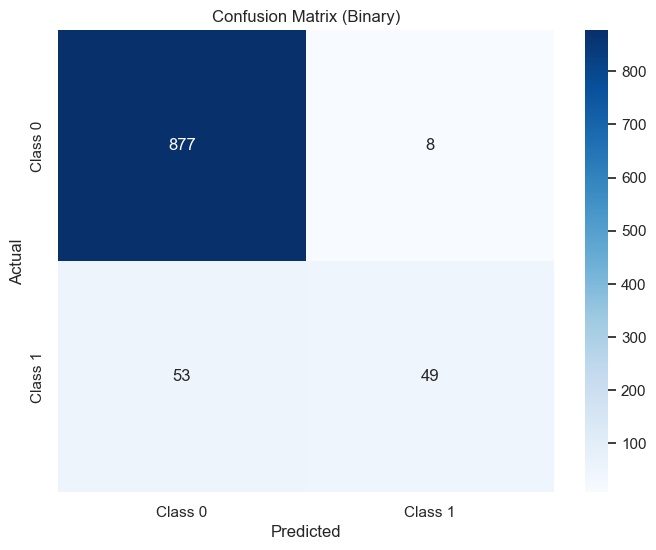

In [143]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix (Binary)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



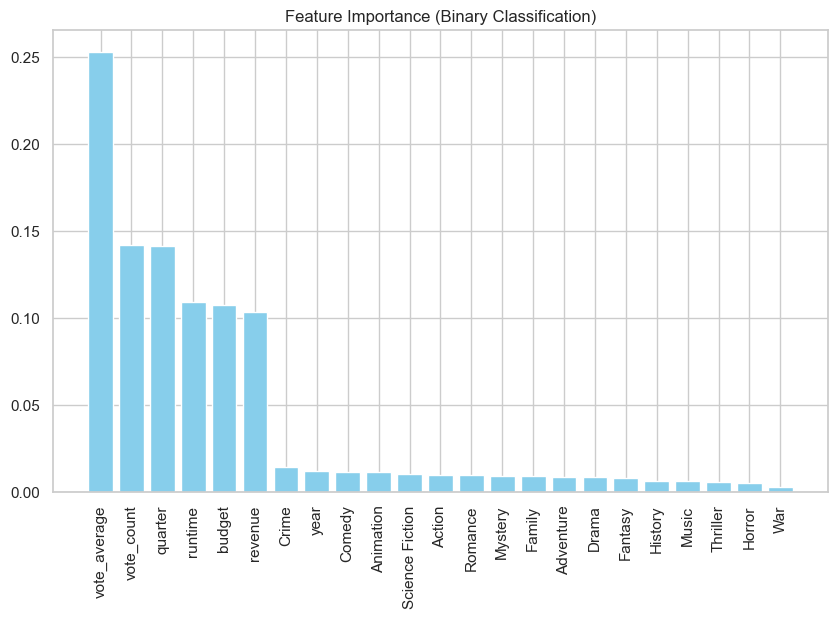

In [144]:
# Optional: Feature Importance
feature_importance = rf_bin.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(feature_importance)[::-1]
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], color='skyblue')
plt.xticks(range(len(feature_importance)), feature_names[sorted_idx], rotation=90)
plt.title('Feature Importance (Binary Classification)')
plt.show()

The feature importance visualization for the Random Forest Classifier highlights the relative contribution of each feature in predicting the binary target variable (Popularity Class). Among all features, vote_average emerges as the most influential factor, significantly surpassing others in importance. This suggests that the average user rating has a substantial impact on the classification of a movie's popularity.

Following vote_average, vote_count and quarter also demonstrate notable importance, indicating that the number of votes and the release period within the year are key predictors. Runtime, budget, and revenue are moderately important, reflecting that financial and runtime attributes play a role but are less decisive than user engagement metrics like votes and ratings.

The remaining features, including genres such as Comedy, Action, Drama, and others, contribute minimally to the model's predictions. Their lower importance suggests that while genre has some relevance, it does not hold as much predictive power compared to user-based and financial features.

This analysis underscores the critical influence of audience perception (ratings and votes) and timing (release quarter) in determining a movie's popularity. For stakeholders aiming to enhance a movie's success, focusing on strategies to increase audience ratings and votes might be more impactful than emphasizing genre or budget adjustments.

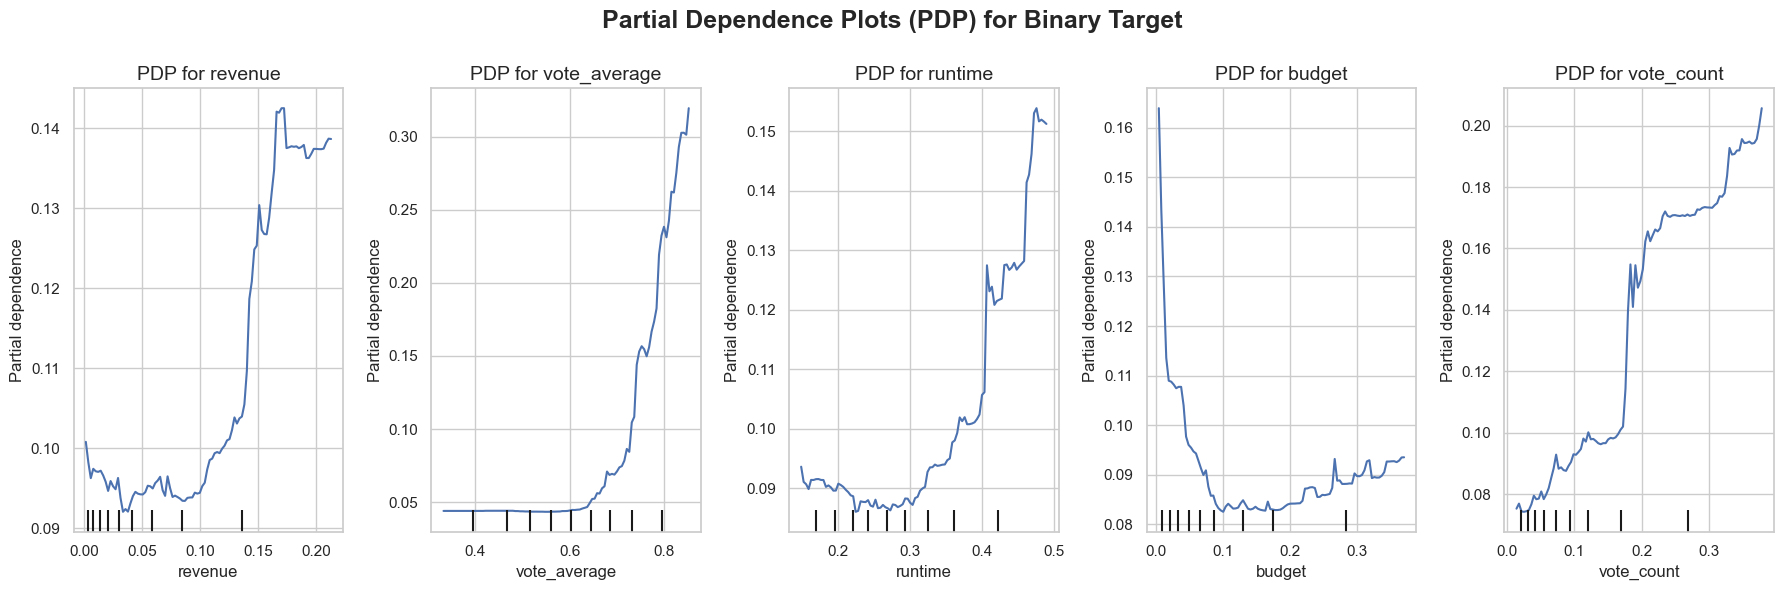

In [146]:
# Train the Random Forest Classifier
rf_bin = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bin.fit(X_train_rf_bin, y_train_rf_bin)

# List of features for Partial Dependence Plots
features = ["revenue", "vote_average", "runtime", "budget", "vote_count"]

# Create subplots for each feature
fig, axes = plt.subplots(1, len(features), figsize=(18, 6))  # Increased figsize for better readability

# If only one feature, axes will not be a list, so ensure it's iterable
if len(features) == 1:
    axes = [axes]

# Plot each feature's Partial Dependence
for i, feature in enumerate(features):
    display = PartialDependenceDisplay.from_estimator(rf_bin, X_train_rf_bin, features=[feature], ax=axes[i])
    axes[i].set_title(f'PDP for {feature}', fontsize=14)  # Larger title font size
    axes[i].set_xlabel(feature, fontsize=12)  # Larger x-axis labels
    axes[i].set_ylabel("Partial Dependence", fontsize=12)  # Larger y-axis labels
    axes[i].tick_params(axis='both', labelsize=10)  # Increase tick label size

# Set a common suptitle for all subplots
plt.suptitle("Partial Dependence Plots (PDP) for Binary Target", fontsize=18, fontweight='bold')
plt.tight_layout()  # Adjust layout to avoid overlap
plt.subplots_adjust(top=0.85)  # Adjust the suptitle position

# Show the plots
plt.show()


The Partial Dependence Plots (PDP) for the binary classification target provide insights into the marginal effect of individual features on the model's prediction for classifying a movie's popularity. Here's a feature-wise interpretation of the PDPs:

Revenue:

As revenue increases, the likelihood of a movie being classified as "Popular" (Class 1) grows steadily, with a notable rise observed at higher revenue values. This indicates that movies generating substantial revenue are more likely to achieve popularity.


Vote Average:

The vote average shows a strong positive relationship with the predicted probability of popularity. Movies with higher user ratings consistently exhibit a higher likelihood of being classified as popular, underlining the critical influence of audience perception.


Runtime:

Runtime suggests an upward trend. Medium-length+  movies are associated with an increase in popularity.


Budget:

The Partial Dependence Plot for budget shows that movies with very low budgets initially have a higher likelihood of being classified as "Popular," but this probability quickly declines as budgets increase slightly.


Vote Count:

Similar to vote average, vote count has a significant positive impact. Movies with a higher number of votes from viewers are strongly associated with increased popularity, reflecting the importance of audience engagement metrics.



Overall, these PDPs emphasize the importance of user-driven metrics like vote average and vote count, while financial (budget) and runtime-related features have more nuanced impacts. Such insights can help guide decisions in marketing, content creation, and resource allocation for films targeting higher popularity.

# Conclusion

Analysis Final Report: Predicting Movie Popularity


This project explores the application of machine learning techniques to analyze and predict movie popularity. By leveraging both supervised and unsupervised methods, we investigated patterns in data, identified key predictive factors, and assessed the performance of various models. The target variables included weighted popularity (w_popularity) for regression tasks and popularity class (popularity_class) for classification tasks, where Class 1 represented "Popular" movies and Class 0 represented "Not Popular" ones.


Data preprocessing was the foundation of this analysis. Numerical features such as budget, revenue, vote_count, vote_average, runtime, and year were normalized using MinMaxScaler, ensuring that features were on comparable scales. Categorical features like genres and quarter were one-hot encoded, enabling them to be used effectively in machine learning models. These steps facilitated the construction of accurate and interpretable models.


To better understand the dataset, we performed exploratory data analysis:

Weighted Popularity Distribution: The weighted popularity values followed a near-normal distribution centered around 8, indicating a balanced dataset for regression analysis.

Popularity Class Distribution: The dataset exhibited an imbalance in the binary target variable, with the majority of movies categorized as "Not Popular" (Class 0).

Trends Over Time: Analysis over time revealed that weighted popularity declined across all quarters. However, budgets and revenues showed a significant upward trend, reflecting increasing financial investments in the movie industry.



Regression Analysis:


Linear Regression Model:

The linear regression model was implemented to predict w_popularity. The model achieved a Mean Absolute Error (MAE) of 0.69, Mean Squared Error (MSE) of 0.84, and an R² score of 0.69. While the model captured linear relationships moderately well, it struggled to account for complex, non-linear patterns in the data.

Random Forest Regressor:

A Random Forest model significantly outperformed linear regression, reducing the Mean Squared Error to 0.83 and achieving an R² score of 0.70. The feature importance analysis revealed that vote_average contributed over 70% to the model’s predictive power. Other features like vote_count, runtime, and budget also played smaller but meaningful roles.



Classification Analysis:

Logistic Regression:

A logistic regression model was employed to classify movies as "Popular" (Class 1) or "Not Popular" (Class 0). The model achieved an accuracy of 93.01%, with strong performance for the majority class (Class 0):

Class 0 metrics: Precision 94%, Recall 99%, and F1-score 96%.
Class 1 metrics: Precision 78%, Recall 39%, and F1-score 52%. However, the model struggled with the minority class, leading to 39 false negatives, which could impact decision-making for underrepresented cases.


K-Nearest Neighbors (KNN):

Using k=5 neighbors, the KNN model achieved an accuracy of 90.58%. The confusion matrix revealed that while the model effectively predicted Class 0, some misclassifications occurred, particularly in overlapping feature spaces. This underscored the need for a more nuanced understanding of feature relationships.


Advanced Classification with Random Forest:

A Random Forest Classifier was applied to predict the binary target popularity_class. The model outperformed logistic regression with an accuracy of 94%. Key metrics included:

Class 0: Precision 94%, Recall 99%, and F1-score 97%.
Class 1: Precision 86%, Recall 48%, and F1-score 62%. The confusion matrix showed 53 false negatives and 8 false positives, with most errors occurring in the minority class. Feature importance analysis revealed that vote_average, vote_count, quarter, budget, revenue and runtime were the most significant predictors, while genre features had minimal impact.


Conclusion:

This project effectively demonstrated the application of supervised (Linear Regression, Logistic Regression, Random Forest) and unsupervised (K-Means) machine learning techniques to analyze movie data. Regression models highlighted the importance of vote_average and vote_count in predicting weighted popularity, while classification models achieved strong performance, particularly for the majority class (the models tend to predict more correctly the failure of movies rather than its success). Clustering provided insights into genre-based groupings, revealing patterns useful for targeted marketing and content recommendations. Overall, the Random Forest models consistently outperformed other methods, offering robust and interpretable predictions.

The project underscores the importance of selecting appropriate models and tuning parameters based on the nature of the target variable, data distribution, and underlying relationships between features. 


